# Install Stuff

In [ ]:
pip install torch-geometric

In [ ]:
pip install openpyxl

In [ ]:
pip install shapely

In [ ]:
pip install pillow

In [ ]:
pip install mplsoccer

In [ ]:
pip install ipywidgets

In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip uninstall torch torchvision torchaudio torchtext torchaudio --yes
!pip uninstall torch_geometric torch_sparse torch_scatter torch_cluster --yes 
!pip cache purge

In [1]:
from torch_geometric.loader import DataLoader
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.data import Batch
from scipy.spatial import Voronoi, voronoi_plot_2d, cKDTree
from shapely.geometry import Polygon, Point
import matplotlib.colors as mcolors
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib
from torch.utils.data import DataLoader as TorchDataLoader 
from sklearn.model_selection import train_test_split 
import time
import copy
from sklearn.calibration import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader as PyGDataLoader 
import torch_geometric.nn as pyg_nn
from matplotlib.lines import Line2D 
import json
import re
from collections import Counter, defaultdict

# Data Prep

In [2]:
df = pd.read_excel('coor.xlsx')

frames = []
player_ids = []
xs = []
ys = []
num_frames_to_process = len(df)

for frame_num, row in df.iterrows():
    ballx = row['ballposX']
    bally = row['ballposY']

    for i in range(32): # adding player data
        player_id = row[f'playerId{i}']
        x = row[f'posX{i}']
        y = row[f'posY{i}']
        if pd.notna(player_id) and pd.notna(x) and pd.notna(y) and x != -100 and y != -100:
            frames.append(frame_num)
            player_ids.append(player_id)
            xs.append(x)
            ys.append(y)

    frames.append(frame_num) # adding ball data
    player_ids.append('ball') 
    xs.append(ballx)
    ys.append(bally)

result_df = pd.DataFrame({ #adding everything to result_df
    'frame': frames,
    'player_id': player_ids,
    'x': xs,
    'y': ys
})

result_df['sort_key'] = result_df['player_id'].apply(lambda pid: 0 if pid == 'ball' else 1) #sorting so ball is first in frame
result_df['player_id_sortable'] = pd.to_numeric(result_df['player_id'], errors='coerce').fillna(float('inf'))
result_df = result_df.sort_values(
    by=['frame', 'sort_key', 'player_id_sortable'],
    ignore_index=True 
).drop(columns=['sort_key', 'player_id_sortable']) 

print(result_df.head(25)) 
print(result_df.shape)

    frame player_id     x     y
0       0      ball  49.0  31.0
1       0     95372  60.0  22.0
2       0     95376  50.0  45.0
3       0     95382  48.0  10.0
4       0     95385  63.0  27.0
5       0     95390  34.0  30.0
6       0     95391  44.0  56.0
7       0     95392  50.0  31.0
8       0     95393  61.0  47.0
9       0     95394  50.0  56.0
10      0     95395  40.0  32.0
11      0     95396  26.0  33.0
12      0     95397  50.0  17.0
13      0     95398  59.0  26.0
14      0     95399  52.0  40.0
15      0     95400  26.0  29.0
16      0     95402  63.0  39.0
17      0     95403  83.0  31.0
18      0     95404   6.0  31.0
19      1      ball  49.0  31.0
20      1     95372  60.0  22.0
21      1     95376  50.0  45.0
22      1     95382  48.0  10.0
23      1     95385  63.0  27.0
24      1     95390  34.0  30.0
(506221, 4)


In [3]:
id_df = pd.read_excel('id.xlsx') #file to get match team
player_team_map = id_df.set_index('id')['Match Team']
result_df['Team'] = result_df['player_id'].map(player_team_map)

In [4]:
original_frames = result_df['frame'].nunique() #code to remove frames from beginning, half time and frames where players are missing
print(f"Original number of unique frames: {original_frames}")

def check_frame_validity(group):
    num_unique_players = group['player_id'].nunique()
    if num_unique_players != 23: #23 because 22 players + 1 ball
        return False 

    team_counts = group['Team'].value_counts() #check to see if both teams are there
    if len(team_counts) != 2:
        return False

    if not (team_counts == 11).all(): # check to see if both teams have 11 players
        return False

    return True

filtered_df = result_df.groupby('frame').filter(check_frame_validity) # based on tests filter out bad frames

filtered_frames = filtered_df['frame'].nunique()
print(f"Number of frames removed: {original_frames - filtered_frames}")

Original number of unique frames: 22368
Number of frames removed: 1984


In [48]:
def count_frames_with_overlapping_players(dataframe): #to check how many frames had overlapping players, to see if it was a significant amount
    player_df = dataframe[dataframe['player_id'] != 'ball'].copy()  # exclude the ball
    overlap_count = 0

    for _, frame_data in player_df.groupby('frame'): #count amount of dupes
        coord_counts = frame_data.groupby(['x', 'y'])['player_id'].nunique()
        if (coord_counts > 1).any():
            overlap_count += 1

    return overlap_count

print(f"Originally {len(filtered_df)} rows.")
frames_with_overlaps = count_frames_with_overlapping_players(filtered_df)
print(f"Frames with dupes: {frames_with_overlaps}")

Originally 468832 rows.
Frames with dupes: 1984


In [5]:
print(filtered_df.shape)

(468832, 5)


In [6]:
test_df = filtered_df.head(66000)
print(test_df)

       frame player_id     x     y           Team
7714     406      ball  33.0  58.0            NaN
7715     406     95342  56.0  49.0  AFC 34 jong 2
7716     406     95372  64.0  31.0  AFC 34 jong 2
7717     406     95376  66.0  58.0  AFC 34 jong 1
7718     406     95379  42.0  52.0  AFC 34 jong 1
...      ...       ...   ...   ...            ...
73709   3275     95386  63.0   0.0  AFC 34 jong 1
73710   3275     95390  65.0   8.0  AFC 34 jong 1
73711   3275     95391  49.0  33.0  AFC 34 jong 1
73712   3275     95392  56.0  10.0  AFC 34 jong 2
73713   3275     95393  79.0  33.0  AFC 34 jong 2

[66000 rows x 5 columns]


# Model training + eval

In [ ]:
def set_seed(seed=42): #setting seed so i can reproduce results
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

field_size = (100, 64) #all my parameters or global variables i need
num_frames_context = 30
prediction_horizon = 15
THRESHOLD_DISTANCE = 30
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.00001
DROPOUT_PROB = 0.2
EPOCHS = 200 
BATCH_SIZE = 1
GNN_HIDDEN_DIM = 128
LSTM_HIDDEN_DIM = 256
TEST_SPLIT_RATIO = 0.2
VALIDATION_SPLIT_RATIO = 0.1
GRID_W, GRID_H = field_size
IGNORE_INDEX = -1
EMBEDDING_DIM = 16 

# DATA LOADING
df = filtered_df
df = df.sort_values(by=['frame', 'player_id']).reset_index(drop=True)
total_frames = df['frame'].nunique()
print(f"Total unique frames in filtered data: {total_frames}")

# MAPPING PLAYERID TO UNIQUE INTERGER INDEX
all_player_ids = df[df['player_id'] != 'ball']['player_id'].astype(str).unique() #exclude ball and turned to string for ease
player_id_to_idx = {player_id: i for i, player_id in enumerate(all_player_ids)}
num_unique_players = len(all_player_ids)

all_player_features_list = []
original_player_positions_list = []
all_player_id_indices_list = []

# ENCODING TEAMS
valid_teams = df[(df['player_id'] != 'ball') & (df['Team'].notna())]['Team'].unique()
team_encoder = LabelEncoder()
team_encoder.fit(valid_teams)
print(f"Team mapping: {list(team_encoder.classes_)} -> {list(range(len(team_encoder.classes_)))}")
TEAMS_AVAILABLE = True

# BALL POSITION CALCULATION & FEATURES
ball_pos_map = {}
ball_data = df[df['player_id'] == 'ball'][['frame', 'x', 'y']].set_index('frame')
for frame_idx, row in ball_data.iterrows():
    ball_pos_map[frame_idx] = (row['x'], row['y'])
ACTUAL_PLAYERS_PER_FRAME = -1
processed_frame_indices = [] # keep track of frames processed
grouped_by_frame = df.groupby('frame')
for frame_num, frame_data in grouped_by_frame:
    bx, by = ball_pos_map.get(frame_num, (None, None)) # get ball position
    if bx is None: continue # skip if ball missing

    player_data = frame_data[frame_data['player_id'] != 'ball'].copy()
    ACTUAL_PLAYERS_PER_FRAME = len(player_data)
    player_data = player_data.sort_values(by='player_id') # sort players by ID (so consistency for 0-21 indexing)

    sorted_player_ids = player_data['player_id'].astype(str).values 
    player_unique_indices = [player_id_to_idx.get(pid, -1) for pid in sorted_player_ids]  # convert playerids to unique integer index

    px = player_data['x'].values # get positions of players
    py = player_data['y'].values
    teams = player_data['Team'].values
    dist_ball = np.sqrt((px - bx)**2 + (py - by)**2) #get ball distance
    rel_bx = px - bx #get relative ball distance 
    rel_by = py - by

    if TEAMS_AVAILABLE: #encode teams, also check since i ran into issue before with the teams
        teams_encoded = []
        for team in teams:
            if pd.isna(team): teams_encoded.append(-1)
            else:
                try: teams_encoded.append(team_encoder.transform([team])[0])
                except ValueError: teams_encoded.append(-1)
        teams_encoded = np.array(teams_encoded)
    else: teams_encoded = np.full(ACTUAL_PLAYERS_PER_FRAME, -1)

    frame_pos_tensor = torch.tensor(np.stack([px, py], axis=-1), dtype=torch.float) #converting data to tensor
    frame_team_tensor = torch.tensor(teams_encoded, dtype=torch.float).unsqueeze(-1)
    frame_ball_features_tensor = torch.tensor(np.stack([dist_ball, rel_bx, rel_by], axis=-1), dtype=torch.float)

    original_player_positions_list.append(frame_pos_tensor.clone()) #store original player position for later 

    frame_features_no_vel = torch.cat((frame_pos_tensor, frame_team_tensor, frame_ball_features_tensor), dim=-1) #combine features
    all_player_features_list.append(frame_features_no_vel)
    all_player_id_indices_list.append(torch.tensor(player_unique_indices, dtype=torch.long))

    processed_frame_indices.append(frame_num) # Log the index of the frame we processed

num_processed_frames = len(all_player_features_list)
print(f"processed {num_processed_frames} frames.") #check since I had some issues before

# VELOCITY CALCULATION
features_no_vel = torch.stack(all_player_features_list, dim=0)
original_positions = torch.stack(original_player_positions_list, dim=0)
player_id_indices_tensor = torch.stack(all_player_id_indices_list, dim=0) 
velocities = original_positions[1:] - original_positions[:-1]
velocities = torch.cat((torch.zeros(1, ACTUAL_PLAYERS_PER_FRAME, 2, device=original_positions.device), velocities), dim=0)

pos_features = features_no_vel[:, :, 0:2] # concatonate the features 
team_features = features_no_vel[:, :, 2:3]
ball_features = features_no_vel[:, :, 3:6]
features_raw = torch.cat((pos_features, velocities, team_features, ball_features), dim=-1)

# NORMALIZING FEATURES FOR MODEL
scaler = StandardScaler()
num_samples_norm, num_players_norm, num_features_norm = features_raw.shape
features_reshaped = features_raw.reshape(-1, num_features_norm)
scaler.fit(features_reshaped)
features_scaled_reshaped = scaler.transform(features_reshaped)
features = torch.tensor(features_scaled_reshaped.reshape(num_samples_norm, num_players_norm, num_features_norm), dtype=torch.float)

# MAKE THE VORONOI LABELS
def compute_voronoi_labels_modified(player_positions_at_frame, num_expected_players, grid_shape=(GRID_W, GRID_H)):
    if isinstance(player_positions_at_frame, torch.Tensor):
        player_positions_at_frame = player_positions_at_frame.cpu().numpy() #need to do this bc i get error if i dont

    unique_positions, unique_indices = np.unique(player_positions_at_frame, axis=0, return_index=True) #for dupes, if only one unique position, fill grid with the index of the first player having that position
    if len(unique_positions) == 0: return np.full((grid_shape[1], grid_shape[0]), IGNORE_INDEX, dtype=np.int64)
    if len(unique_positions) == 1: return np.full((grid_shape[1], grid_shape[0]), unique_indices[0], dtype=np.int64)

    tree = cKDTree(unique_positions) 
    grid_x, grid_y = np.meshgrid(np.linspace(0.5, grid_shape[0] - 0.5, grid_shape[0]), np.linspace(0.5, grid_shape[1] - 0.5, grid_shape[1]))
    grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    _, nearest_unique_idx = tree.query(grid_points, k=1)
    original_player_indices = unique_indices[nearest_unique_idx]
    label_grid = original_player_indices.reshape(grid_shape[1], grid_shape[0])
    return label_grid.astype(np.int64)

all_space_dominance_maps = []
for t in range(len(original_positions)): #actually compute all the voronoi labels
    positions_t = original_positions[t]
    vor_map = compute_voronoi_labels_modified(positions_t, ACTUAL_PLAYERS_PER_FRAME, grid_shape=(GRID_W, GRID_H))
    all_space_dominance_maps.append(vor_map)
print("Done with voronoi labels")

# FUNCTION TO CREATE GRAPH EDGES - created with help of gemini due to many bugs I had
def create_edges_for_single_frame_modified(frame_positions, threshold_distance=THRESHOLD_DISTANCE):
    num_players_edge, _ = frame_positions.shape
    edge_index = []
    for i in range(num_players_edge):
        for j in range(i + 1, num_players_edge):
            pos_i = frame_positions[i]
            pos_j = frame_positions[j]
            if torch.isfinite(pos_i).all() and torch.isfinite(pos_j).all():
                dist = torch.norm(pos_i - pos_j)
                if dist < threshold_distance:
                    edge_index.append([i, j])
                    edge_index.append([j, i])

    if not edge_index: return torch.empty((2, 0), dtype=torch.long)
    else: return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

print("start edge")
all_frame_edges = []
for t in range(len(original_positions)):
    frame_pos = original_positions[t]
    edge_list_t = create_edges_for_single_frame_modified(frame_pos, THRESHOLD_DISTANCE)
    all_frame_edges.append(edge_list_t)
print("finish edge")

# CREATING THE DATA SAMPLES
data_list = []
max_start_t = num_processed_frames - num_frames_context - prediction_horizon

print("Start making samples")
for t in range(max_start_t + 1):
    start_idx = t
    end_idx_context = t + num_frames_context
    target_frame_idx = end_idx_context - 1 + prediction_horizon
    original_target_frame_num = processed_frame_indices[target_frame_idx] if target_frame_idx < len(processed_frame_indices) else -1

    if target_frame_idx >= len(all_space_dominance_maps) or \
        target_frame_idx >= len(original_positions) or \
        original_target_frame_num not in ball_pos_map: 
        continue

    seq_features = features[start_idx:end_idx_context] #all things that go in sample (features, edges, label, etc..)
    seq_edges = all_frame_edges[start_idx:end_idx_context]
    target_map = all_space_dominance_maps[target_frame_idx]
    ball_pos_target = ball_pos_map.get(original_target_frame_num) 
    seq_player_indices = player_id_indices_tensor[start_idx:end_idx_context]

    if target_map is not None and not np.all(target_map == IGNORE_INDEX) and ball_pos_target is not None: 
            data = Data(
                x=seq_features,                  
                edge_indices=seq_edges,
                y=torch.tensor(target_map, dtype=torch.long),
                target_idx=target_frame_idx, 
                ball_pos=torch.tensor(ball_pos_target, dtype=torch.float),
                player_indices=seq_player_indices 
            )
            data_list.append(data)
print("Finish making samples")

# TRAIN TEST SPLIT
train_val_data, test_data = train_test_split(data_list, test_size=TEST_SPLIT_RATIO, random_state=42, shuffle=True)
train_subset_data, validation_data = train_test_split(train_val_data, test_size=0.1250, random_state=42)
print(f"Data split: {len(train_subset_data)} training samples, {len(validation_data)} validation samples, {len(test_data)} testing samples")

# GNN-LSTM MODEL
class GNNLSTM(nn.Module):
    def __init__(self, in_features, gnn_hidden_dim, lstm_hidden_dim, num_classes,
                 dropout_prob, num_unique_players, embedding_dim, grid_shape=(GRID_W, GRID_H)):
        super(GNNLSTM, self).__init__()
        print(f"Initializing GNN-LSTM: feat_in={in_features}, gnn={gnn_hidden_dim}, lstm={lstm_hidden_dim}, classes={num_classes}, drop={dropout_prob}, unique_players={num_unique_players}, embed_dim={embedding_dim}")
        self.gnn_hidden_dim = gnn_hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_classes = num_classes 
        self.grid_h, self.grid_w = grid_shape[1], grid_shape[0]
        self.player_embedding = nn.Embedding(num_embeddings=num_unique_players, embedding_dim=embedding_dim) #player mebdding layer
        gnn_input_dim = in_features + embedding_dim

        self.gnn1 = GCNConv(gnn_input_dim, gnn_hidden_dim)
        self.gnn2 = GCNConv(gnn_hidden_dim, gnn_hidden_dim)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.lstm = nn.LSTM(gnn_hidden_dim, lstm_hidden_dim, batch_first=True)

        upsample_channels = 128
        self.start_h, self.start_w = 4, 7
        self.fc_project = nn.Linear(lstm_hidden_dim, upsample_channels * self.start_h * self.start_w)
        self.upconv1 = nn.ConvTranspose2d(upsample_channels, 64, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.InstanceNorm2d(64, affine=True)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.InstanceNorm2d(32, affine=True)
        self.upconv3 = nn.ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=2, padding=(1, 4))
        self.bn3 = nn.InstanceNorm2d(16, affine=True)
        self.upconv4 = nn.ConvTranspose2d(16, self.num_classes, kernel_size=4, stride=2, padding=1)

    def forward(self, data):
        x, edge_indices_list, player_indices = data.x, data.edge_indices, data.player_indices
        seq_len, num_players_fwd, feat_dim = x.shape
        current_batch_size = BATCH_SIZE 

        gnn_step_outputs = []
        for t in range(seq_len):
            x_t = x[t] 
            player_indices_t = player_indices[t].to(x_t.device) 

            if player_indices_t.dtype != torch.long: #make sure player indices are long type which is needed
                player_indices_t = player_indices_t.long()

            id_embeddings_t = self.player_embedding(player_indices_t) 
            x_combined_t = torch.cat([x_t, id_embeddings_t], dim=-1) 

            if t < len(edge_indices_list):
                 edge_index_t = edge_indices_list[t].to(x_t.device)

            gnn_out_t = F.relu(self.gnn1(x_combined_t, edge_index_t)) #pass eveerything to gnn
            gnn_out_t = self.dropout(gnn_out_t)
            gnn_out_t = F.relu(self.gnn2(gnn_out_t, edge_index_t))
            gnn_out_t = self.dropout(gnn_out_t)
            agg_gnn_out_t = gnn_out_t.mean(dim=0)
            gnn_step_outputs.append(agg_gnn_out_t)

        lstm_in = torch.stack(gnn_step_outputs, dim=0).unsqueeze(0) #give to lstm
        lstm_out, _ = self.lstm(lstm_in)
        last_lstm_out = lstm_out[:, -1, :]

        up_x = self.fc_project(last_lstm_out) #decoder to predict 
        up_x = self.dropout(up_x)
        up_x = up_x.view(current_batch_size, -1, self.start_h, self.start_w)
        up_x = F.relu(self.bn1(self.upconv1(up_x)))
        up_x = F.relu(self.bn2(self.upconv2(up_x)))
        up_x = F.relu(self.bn3(self.upconv3(up_x)))
        output_logits = self.upconv4(up_x)

        return output_logits

# TRAINING
device = torch.device('cpu')
print(f"Using device: {device}")

final_num_features = features.shape[-1] 
final_num_players_on_field = features.shape[1] 
model = GNNLSTM(
    in_features=final_num_features, 
    gnn_hidden_dim=GNN_HIDDEN_DIM,
    lstm_hidden_dim=LSTM_HIDDEN_DIM,
    num_classes=final_num_players_on_field, 
    dropout_prob=DROPOUT_PROB,
    num_unique_players=num_unique_players, 
    embedding_dim=EMBEDDING_DIM,         
    grid_shape=(GRID_W, GRID_H)
).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
loss_fn = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

train_loader = PyGDataLoader(train_subset_data, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = PyGDataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=False) 
test_loader = PyGDataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False) 

# EARLY STOPPING
patience = 10
epochs_no_improve = 0
best_val_loss = float('inf')
best_model_state_dict = None
early_stop_triggered = False

print("START TRAINING!!!!!")
training_start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    model.train()
    total_train_loss = 0
    processed_batches = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        target = data.y
        if target.dim() == 2: 
            target = target.unsqueeze(0) 

        optimizer.zero_grad()
        pred_logits = model(data)
        loss = loss_fn(pred_logits, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()
        processed_batches += 1

    avg_train_loss = total_train_loss / processed_batches 

    avg_val_loss = float('inf') # Validation phase
    model.eval()
    total_val_loss = 0
    val_batches = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            data = data.to(device)
            target = data.y
            if target.dim() == 2: target = target.unsqueeze(0)

            pred_logits = model(data)
            loss = loss_fn(pred_logits, target)

            total_val_loss += loss.item()
            val_batches += 1

    avg_val_loss = total_val_loss / val_batches 

    epoch_duration = time.time() - epoch_start_time
    print(f'Epoch {epoch}/{EPOCHS-1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Duration: {epoch_duration:.2f}s')

    # LR SCHEDULER
    if val_loader and avg_val_loss != float('inf'): 
        scheduler.step(avg_val_loss)

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        if val_loader: 
            best_model_state_dict = copy.deepcopy(model.state_dict())
            print(f'  Validation loss improved to {best_val_loss:.4f}. Saving model')
    else:
        epochs_no_improve += 1
        if val_loader:
                print(f'  Validation loss did not improve for {epochs_no_improve} epochs.')

    if val_loader and epochs_no_improve >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs.')
        early_stop_triggered = True
        break # Exit training loop

training_duration = time.time() - training_start_time
print(f"\nTraining finished in {training_duration:.2f} seconds.")
if early_stop_triggered: print(f"Early stopping occurred at epoch {epoch+1}.")

print(f"Loading model weights from epoch with best validation loss: {best_val_loss:.4f}")
model.load_state_dict(best_model_state_dict)

Total unique frames in filtered data: 20384
Team mapping: ['AFC 34 jong 1', 'AFC 34 jong 2'] -> [0, 1]
processed 20384 frames.
Done with voronoi labels
start edge
finish edge
Start making samples
Finish making samples
Data split: 14238 training samples, 2034 validation samples, 4068 testing samples
Using device: cpu
Initializing GNN-LSTM: feat_in=8, gnn=128, lstm=256, classes=22, drop=0.2, unique_players=29, embed_dim=16
START TRAINING!!!!!
Epoch 0/199 | Train Loss: 1.2009 | Val Loss: 0.8680 | Duration: 953.02s
  Validation loss improved to 0.8680. Saving model
Epoch 1/199 | Train Loss: 0.7969 | Val Loss: 0.7104 | Duration: 952.60s
  Validation loss improved to 0.7104. Saving model
Epoch 2/199 | Train Loss: 0.6642 | Val Loss: 0.5713 | Duration: 949.36s
  Validation loss improved to 0.5713. Saving model
Epoch 3/199 | Train Loss: 0.5772 | Val Loss: 0.5273 | Duration: 947.60s
  Validation loss improved to 0.5273. Saving model
Epoch 4/199 | Train Loss: 0.5241 | Val Loss: 0.4641 | Duration:

<All keys matched successfully>

In [8]:
model.eval() 
total_test_loss = 0.0
total_correct_pixels = 0
total_pixels_evaluated = 0
num_classes = 22
total_intersection_per_class = torch.zeros(num_classes, dtype=torch.float64, device='cpu')
total_union_per_class = torch.zeros(num_classes, dtype=torch.float64, device='cpu')
start_time = time.time()

with torch.no_grad():  
    for i, data in enumerate(test_loader):
        data.x = data.x.to(device)
        data.y = data.y.to(device) 

        pred_logits = model(data) 
        target = data.y.unsqueeze(0) 

        loss = loss_fn(pred_logits, target)
        total_test_loss += loss.item()

        predicted_labels = torch.argmax(pred_logits, dim=1) 

        valid_pixel_mask = (target != IGNORE_INDEX)
        correct_pixels_batch = ((predicted_labels == target) & valid_pixel_mask).sum().item()
        total_pixels_batch = valid_pixel_mask.sum().item()

        total_correct_pixels += correct_pixels_batch
        total_pixels_evaluated += total_pixels_batch

        pred_labels_cpu = predicted_labels.squeeze(0).cpu() 
        target_cpu = target.squeeze(0).cpu() 
        valid_mask_cpu = (target_cpu != IGNORE_INDEX)

        for c in range(num_classes): 
            pred_mask_c = (pred_labels_cpu == c) & valid_mask_cpu
            target_mask_c = (target_cpu == c) & valid_mask_cpu

            intersection = (pred_mask_c & target_mask_c).sum() 
            union = (pred_mask_c | target_mask_c).sum() 

            total_intersection_per_class[c] += intersection.double() #
            total_union_per_class[c] += union.double()

eval_duration = time.time() - start_time
num_test_samples = len(test_loader)
avg_test_loss = total_test_loss / num_test_samples if num_test_samples > 0 else 0.0
pixel_accuracy = (total_correct_pixels / total_pixels_evaluated) * 100 if total_pixels_evaluated > 0 else 0.0
iou_per_class = torch.zeros(num_classes, dtype=torch.float64, device='cpu')
valid_union_mask = total_union_per_class > 0
iou_per_class[valid_union_mask] = total_intersection_per_class[valid_union_mask] / total_union_per_class[valid_union_mask]
iou_per_class[~valid_union_mask] = 0.0 
mean_iou = iou_per_class[valid_union_mask].mean().item()

print("\n--- Test Set Evaluation Results ---")
print(f"Evaluation completed in {eval_duration:.2f} seconds.")
print(f'Average Test Loss: {avg_test_loss:.4f}')
print(f'Overall Pixel Accuracy: {pixel_accuracy:.2f}%')
print(f'  (Calculated on {total_correct_pixels} correct pixels out of {total_pixels_evaluated} valid pixels)')
print(f'Mean IoU (mIoU): {mean_iou:.4f}')
print("-----------------------------------")

print("\n--- Per-Class IoU ---")
for c in range(num_classes):
    iou_c = iou_per_class[c].item()
    status = "(Class Present)" if valid_union_mask[c] else "(Class Absent)"
    print(f'  Class (Player Index) {c:2d}: {iou_c:.4f} {status}')
print("---------------------")

test_metrics = {
    "avg_loss": avg_test_loss,
    "pixel_accuracy": pixel_accuracy,
    "mIoU": mean_iou,
    "per_class_iou": iou_per_class.cpu().numpy() 
}


--- Test Set Evaluation Results ---
Evaluation completed in 168.96 seconds.
Average Test Loss: 0.1403
Overall Pixel Accuracy: 94.79%
  (Calculated on 24679137 correct pixels out of 26035200 valid pixels)
Mean IoU (mIoU): 0.8670
-----------------------------------

--- Per-Class IoU ---
  Class (Player Index)  0: 0.7737 (Class Present)
  Class (Player Index)  1: 0.8672 (Class Present)
  Class (Player Index)  2: 0.8736 (Class Present)
  Class (Player Index)  3: 0.8593 (Class Present)
  Class (Player Index)  4: 0.9693 (Class Present)
  Class (Player Index)  5: 0.8743 (Class Present)
  Class (Player Index)  6: 0.7861 (Class Present)
  Class (Player Index)  7: 0.8479 (Class Present)
  Class (Player Index)  8: 0.8096 (Class Present)
  Class (Player Index)  9: 0.8573 (Class Present)
  Class (Player Index) 10: 0.8535 (Class Present)
  Class (Player Index) 11: 0.8467 (Class Present)
  Class (Player Index) 12: 0.8726 (Class Present)
  Class (Player Index) 13: 0.8664 (Class Present)
  Class (Pla

In [60]:
model.load_state_dict(torch.load('base+ball+id+threshold_30+double_hidden.pth'))

<All keys matched successfully>

In [9]:
torch.save(model.state_dict(), f"base+ball+id+threshold_30+double_hidden+200_epoch.pth")

# Graphs

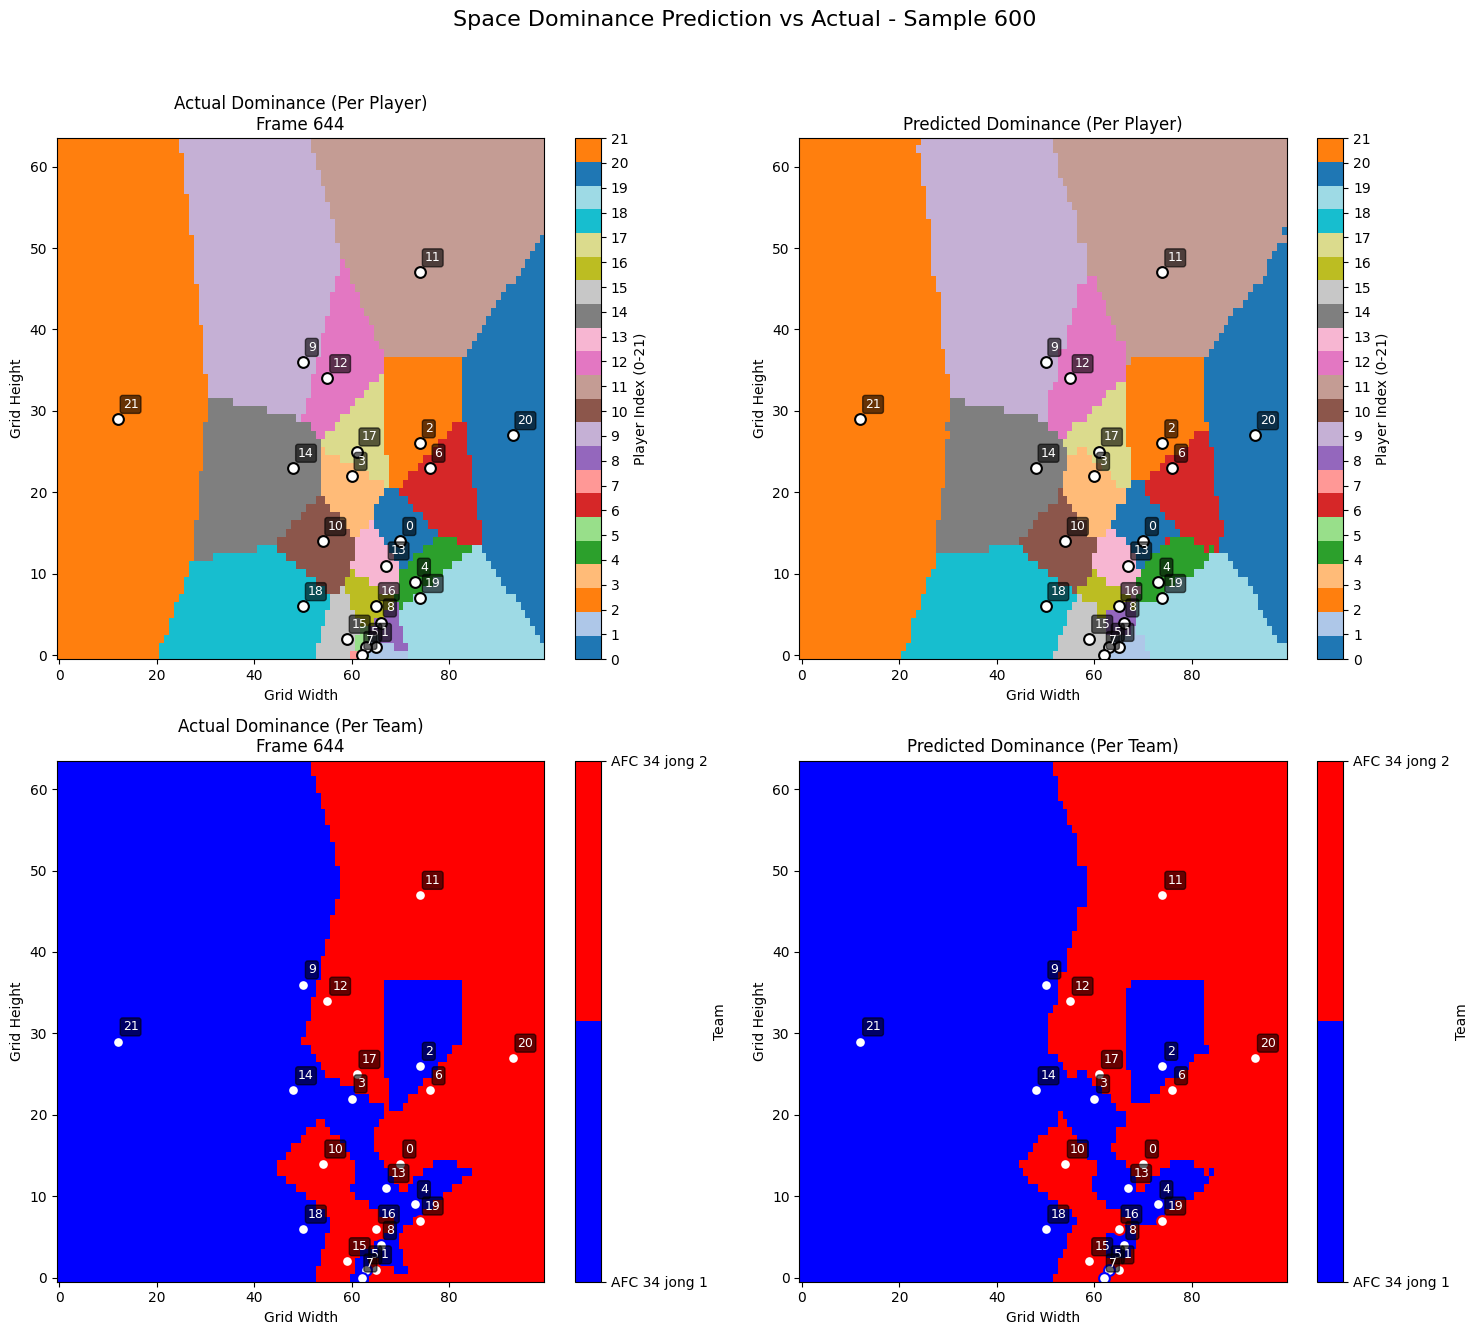

In [10]:
model.eval() 
with torch.no_grad():
    if len(data_list) > 0:
        sample_index = 600 
        eval_data = data_list[sample_index]
        PLAYERS_PER_FRAME = 22
        start_idx_context = sample_index
        end_idx_context = start_idx_context + num_frames_context
        target_frame_idx = end_idx_context - 1 + prediction_horizon
        actual_player_positions_np = original_positions[target_frame_idx].cpu().numpy()
        num_actual_players = actual_player_positions_np.shape[0]

        features_raw_target_frame = features_raw[target_frame_idx] #get features and stuff
        team_indices_tensor = features_raw_target_frame[:, 4]
        player_index_to_team_map = team_indices_tensor.cpu().numpy().astype(int)

        eval_data.x = eval_data.x.to(device)
        eval_data.y = eval_data.y.to(device) 
        pred_logits = model(eval_data)
        pred_labels = torch.argmax(pred_logits, dim=1)

        pred_labels_grid_np = pred_labels.squeeze(0).cpu().numpy() 
        actual_labels_grid_np = eval_data.y.cpu().numpy() 
        team_ignore_val = -1 

        pred_team_grid_np = np.full_like(pred_labels_grid_np, fill_value=team_ignore_val, dtype=int)
        for player_idx in range(num_actual_players): 
            team_idx = player_index_to_team_map[player_idx]
            pred_team_grid_np[pred_labels_grid_np == player_idx] = team_idx

        actual_team_grid_np = np.full_like(actual_labels_grid_np, fill_value=team_ignore_val, dtype=int)
        valid_actual_player_indices = np.unique(actual_labels_grid_np[actual_labels_grid_np != IGNORE_INDEX])
        for player_idx in valid_actual_player_indices:
            if 0 <= player_idx < num_actual_players:
                    team_idx = player_index_to_team_map[player_idx]
                    actual_team_grid_np[actual_labels_grid_np == player_idx] = team_idx

        fig, ax = plt.subplots(2, 2, figsize=(15, 14)) 
        cmap_tab20 = plt.get_cmap('tab20')
        cmap_tab10 = plt.get_cmap('tab10')
        cmap_colors_22 = list(cmap_tab20.colors) + list(cmap_tab10.colors[:num_actual_players-20])
        cmap_colors_22 = cmap_colors_22[:num_actual_players]
        plot_cmap_22 = matplotlib.colors.ListedColormap(cmap_colors_22)

        plot_vmax_22 = num_actual_players - 1
        plot_vmin_22 = 0
        team_colors = ["blue", "red"]
        plot_cmap_team = matplotlib.colors.ListedColormap(team_colors)
        plot_vmax_team = 1
        plot_vmin_team = 0
        team_names = list(team_encoder.classes_)

        def plot_players(axis, positions, p_to_t_map=None, color_map=None, v_max=None, text_color='white'):
            num_players = positions.shape[0]
            for p_idx in range(num_players):
                px, py = positions[p_idx]
                marker_edge_color = 'black'
                if p_to_t_map is not None and color_map is not None: 
                        t_idx = p_to_t_map[p_idx]
                        marker_edge_color = color_map(t_idx / v_max if v_max > 0 else 0)

                axis.scatter(px, py, marker='o', s=60, facecolors='white', edgecolors=marker_edge_color, linewidth=1.5)
                axis.text(px + 1, py + 1, str(p_idx), color=text_color, fontsize=9, ha='left', va='bottom',
                            bbox=dict(facecolor='black', alpha=0.6, pad=0.1, boxstyle='round,pad=0.2'))


        #Plotting
        actual_labels_masked = np.ma.masked_where(actual_labels_grid_np == IGNORE_INDEX, actual_labels_grid_np)
        im1 = ax[0, 0].imshow(actual_labels_masked, cmap=plot_cmap_22, origin='lower', aspect='auto', vmin=plot_vmin_22, vmax=plot_vmax_22, interpolation='nearest')
        ax[0, 0].set_title(f"Actual Dominance (Per Player)\nFrame {target_frame_idx}")
        ax[0, 0].set_xlabel("Grid Width")
        ax[0, 0].set_ylabel("Grid Height")
        cbar1 = fig.colorbar(im1, ax=ax[0, 0], ticks=np.arange(num_actual_players), label='Player Index (0-21)')
        plot_players(ax[0, 0], actual_player_positions_np) 

        im2 = ax[0, 1].imshow(pred_labels_grid_np, cmap=plot_cmap_22, origin='lower', aspect='auto', vmin=plot_vmin_22, vmax=plot_vmax_22, interpolation='nearest')
        ax[0, 1].set_title("Predicted Dominance (Per Player)")
        ax[0, 1].set_xlabel("Grid Width")
        ax[0, 1].set_ylabel("Grid Height")
        cbar2 = fig.colorbar(im2, ax=ax[0, 1], ticks=np.arange(num_actual_players), label='Player Index (0-21)')
        plot_players(ax[0, 1], actual_player_positions_np)

        actual_team_grid_masked = np.ma.masked_where(actual_team_grid_np == team_ignore_val, actual_team_grid_np)
        im3 = ax[1, 0].imshow(actual_team_grid_masked, cmap=plot_cmap_team, origin='lower', aspect='auto', vmin=plot_vmin_team, vmax=plot_vmax_team, interpolation='nearest')
        ax[1, 0].set_title(f"Actual Dominance (Per Team)\nFrame {target_frame_idx}")
        ax[1, 0].set_xlabel("Grid Width")
        ax[1, 0].set_ylabel("Grid Height")
        cbar3 = fig.colorbar(im3, ax=ax[1, 0], ticks=[0, 1], label='Team')
        cbar3.ax.set_yticklabels(team_names)
        plot_players(ax[1, 0], actual_player_positions_np, player_index_to_team_map, plot_cmap_team, plot_vmax_team)

        pred_team_grid_masked = np.ma.masked_where(pred_team_grid_np == team_ignore_val, pred_team_grid_np)
        im4 = ax[1, 1].imshow(pred_team_grid_masked, cmap=plot_cmap_team, origin='lower', aspect='auto', vmin=plot_vmin_team, vmax=plot_vmax_team, interpolation='nearest')
        ax[1, 1].set_title("Predicted Dominance (Per Team)")
        ax[1, 1].set_xlabel("Grid Width")
        ax[1, 1].set_ylabel("Grid Height")
        cbar4 = fig.colorbar(im4, ax=ax[1, 1], ticks=[0, 1], label='Team')
        cbar4.ax.set_yticklabels(team_names)
        plot_players(ax[1, 1], actual_player_positions_np, player_index_to_team_map, plot_cmap_team, plot_vmax_team) 

        plt.tight_layout(rect=[0, 0.03, 1, 0.93]) 
        plt.suptitle(f"Space Dominance Prediction vs Actual - Sample {sample_index}", fontsize=16, y=0.98)
        plt.show()

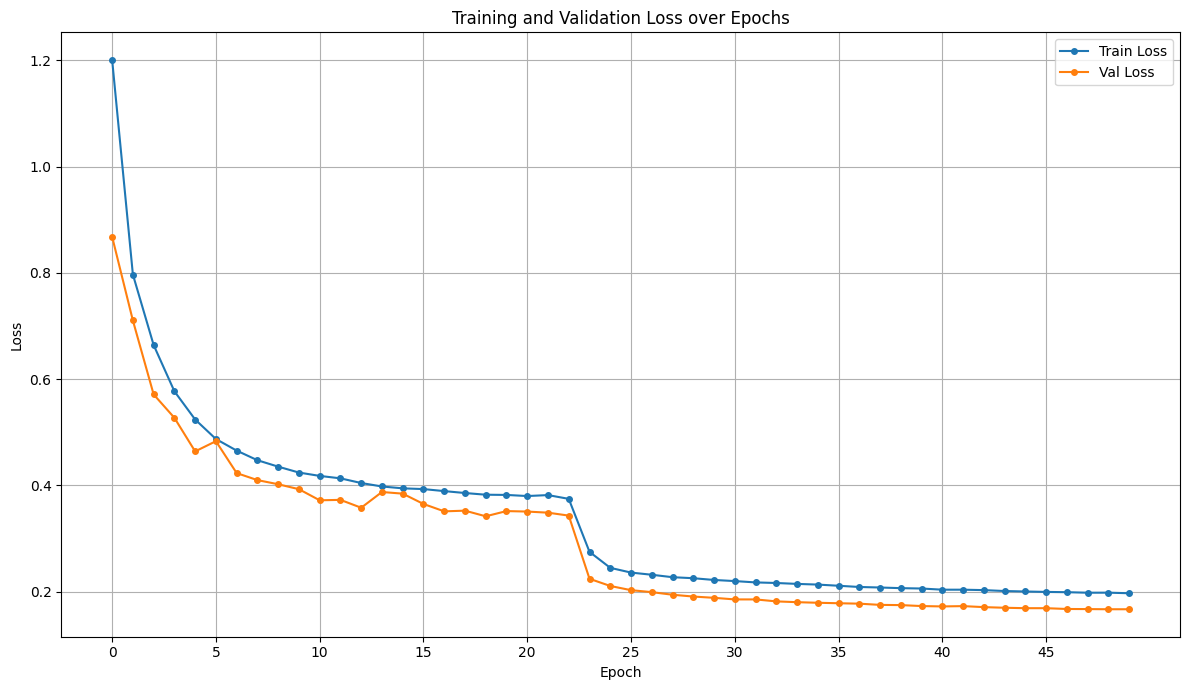

In [ ]:
data = """ch 0/49 | Train Loss: 1.2009 | Val Loss: 0.8680 | Duration: 982.06s
  Validation loss improved to 0.8680. Saving model...
Epoch 1/49 | Train Loss: 0.7969 | Val Loss: 0.7104 | Duration: 1012.39s
  Validation loss improved to 0.7104. Saving model...
Epoch 2/49 | Train Loss: 0.6642 | Val Loss: 0.5713 | Duration: 1004.67s
  Validation loss improved to 0.5713. Saving model...
Epoch 3/49 | Train Loss: 0.5772 | Val Loss: 0.5273 | Duration: 1002.46s
  Validation loss improved to 0.5273. Saving model...
Epoch 4/49 | Train Loss: 0.5241 | Val Loss: 0.4641 | Duration: 1003.00s
  Validation loss improved to 0.4641. Saving model...
Epoch 5/49 | Train Loss: 0.4874 | Val Loss: 0.4833 | Duration: 994.44s
  Validation loss did not improve for 1 epoch(s).
Epoch 6/49 | Train Loss: 0.4656 | Val Loss: 0.4233 | Duration: 999.59s
  Validation loss improved to 0.4233. Saving model...
Epoch 7/49 | Train Loss: 0.4475 | Val Loss: 0.4101 | Duration: 1004.70s
  Validation loss improved to 0.4101. Saving model...
Epoch 8/49 | Train Loss: 0.4354 | Val Loss: 0.4023 | Duration: 1000.18s
  Validation loss improved to 0.4023. Saving model...
Epoch 9/49 | Train Loss: 0.4243 | Val Loss: 0.3930 | Duration: 1005.54s
  Validation loss improved to 0.3930. Saving model...
Epoch 10/49 | Train Loss: 0.4180 | Val Loss: 0.3721 | Duration: 1008.91s
  Validation loss improved to 0.3721. Saving model...
Epoch 11/49 | Train Loss: 0.4134 | Val Loss: 0.3729 | Duration: 1007.11s
  Validation loss did not improve for 1 epoch(s).
Epoch 12/49 | Train Loss: 0.4046 | Val Loss: 0.3581 | Duration: 1004.49s
  Validation loss improved to 0.3581. Saving model...
Epoch 13/49 | Train Loss: 0.3981 | Val Loss: 0.3877 | Duration: 1013.97s
  Validation loss did not improve for 1 epoch(s).
Epoch 14/49 | Train Loss: 0.3946 | Val Loss: 0.3846 | Duration: 1019.80s
  Validation loss did not improve for 2 epoch(s).
Epoch 15/49 | Train Loss: 0.3932 | Val Loss: 0.3652 | Duration: 1006.81s
  Validation loss did not improve for 3 epoch(s).
Epoch 16/49 | Train Loss: 0.3894 | Val Loss: 0.3513 | Duration: 1019.66s
  Validation loss improved to 0.3513. Saving model...
Epoch 17/49 | Train Loss: 0.3858 | Val Loss: 0.3526 | Duration: 1024.19s
  Validation loss did not improve for 1 epoch(s).
Epoch 18/49 | Train Loss: 0.3826 | Val Loss: 0.3420 | Duration: 1014.92s
  Validation loss improved to 0.3420. Saving model...
Epoch 19/49 | Train Loss: 0.3822 | Val Loss: 0.3518 | Duration: 1015.39s
  Validation loss did not improve for 1 epoch(s).
Epoch 20/49 | Train Loss: 0.3801 | Val Loss: 0.3509 | Duration: 1014.81s
  Validation loss did not improve for 2 epoch(s).
Epoch 21/49 | Train Loss: 0.3819 | Val Loss: 0.3488 | Duration: 1021.34s
  Validation loss did not improve for 3 epoch(s).
Epoch 22/49 | Train Loss: 0.3748 | Val Loss: 0.3433 | Duration: 1021.89s
  Validation loss did not improve for 4 epoch(s).
Epoch 23/49 | Train Loss: 0.2751 | Val Loss: 0.2244 | Duration: 1009.26s
  Validation loss improved to 0.2244. Saving model...
Epoch 24/49 | Train Loss: 0.2450 | Val Loss: 0.2109 | Duration: 1011.19s
  Validation loss improved to 0.2109. Saving model...
Epoch 25/49 | Train Loss: 0.2361 | Val Loss: 0.2030 | Duration: 1027.85s
  Validation loss improved to 0.2030. Saving model...
Epoch 26/49 | Train Loss: 0.2320 | Val Loss: 0.1993 | Duration: 1029.02s
  Validation loss improved to 0.1993. Saving model...
Epoch 27/49 | Train Loss: 0.2274 | Val Loss: 0.1944 | Duration: 1034.19s
  Validation loss improved to 0.1944. Saving model...
Epoch 28/49 | Train Loss: 0.2255 | Val Loss: 0.1910 | Duration: 1039.47s
  Validation loss improved to 0.1910. Saving model...
Epoch 29/49 | Train Loss: 0.2222 | Val Loss: 0.1886 | Duration: 1030.93s
  Validation loss improved to 0.1886. Saving model...
Epoch 30/49 | Train Loss: 0.2201 | Val Loss: 0.1856 | Duration: 1031.80s
  Validation loss improved to 0.1856. Saving model...
Epoch 31/49 | Train Loss: 0.2176 | Val Loss: 0.1856 | Duration: 1033.92s
  Validation loss improved to 0.1856. Saving model...
Epoch 32/49 | Train Loss: 0.2165 | Val Loss: 0.1819 | Duration: 1031.73s
  Validation loss improved to 0.1819. Saving model...
Epoch 33/49 | Train Loss: 0.2148 | Val Loss: 0.1804 | Duration: 1085.88s
  Validation loss improved to 0.1804. Saving model...
Epoch 34/49 | Train Loss: 0.2135 | Val Loss: 0.1793 | Duration: 1204.02s
  Validation loss improved to 0.1793. Saving model...
Epoch 35/49 | Train Loss: 0.2113 | Val Loss: 0.1784 | Duration: 1092.32s
  Validation loss improved to 0.1784. Saving model...
Epoch 36/49 | Train Loss: 0.2090 | Val Loss: 0.1776 | Duration: 1040.30s
  Validation loss improved to 0.1776. Saving model...
Epoch 37/49 | Train Loss: 0.2080 | Val Loss: 0.1753 | Duration: 1055.56s
  Validation loss improved to 0.1753. Saving model...
Epoch 38/49 | Train Loss: 0.2068 | Val Loss: 0.1749 | Duration: 1098.48s
  Validation loss improved to 0.1749. Saving model...
Epoch 39/49 | Train Loss: 0.2061 | Val Loss: 0.1731 | Duration: 1091.61s
  Validation loss improved to 0.1731. Saving model...
Epoch 40/49 | Train Loss: 0.2039 | Val Loss: 0.1724 | Duration: 1164.23s
  Validation loss improved to 0.1724. Saving model...
Epoch 41/49 | Train Loss: 0.2039 | Val Loss: 0.1730 | Duration: 987.55s
  Validation loss did not improve for 1 epoch(s).
Epoch 42/49 | Train Loss: 0.2031 | Val Loss: 0.1711 | Duration: 986.48s
  Validation loss improved to 0.1711. Saving model...
Epoch 43/49 | Train Loss: 0.2014 | Val Loss: 0.1699 | Duration: 977.43s
  Validation loss improved to 0.1699. Saving model...
Epoch 44/49 | Train Loss: 0.2005 | Val Loss: 0.1691 | Duration: 978.02s
  Validation loss improved to 0.1691. Saving model...
Epoch 45/49 | Train Loss: 0.1997 | Val Loss: 0.1691 | Duration: 1058.98s
  Validation loss did not improve for 1 epoch(s).
Epoch 46/49 | Train Loss: 0.1992 | Val Loss: 0.1676 | Duration: 1316.31s
  Validation loss improved to 0.1676. Saving model...
Epoch 47/49 | Train Loss: 0.1982 | Val Loss: 0.1674 | Duration: 1364.40s
  Validation loss improved to 0.1674. Saving model...
Epoch 48/49 | Train Loss: 0.1983 | Val Loss: 0.1671 | Duration: 1330.91s
  Validation loss improved to 0.1671. Saving model...
Epoch 49/49 | Train Loss: 0.1972 | Val Loss: 0.1671 | Duration: 1343.66s
"""

epochs = []
train_losses = []
val_losses = []

for line in data.strip().split('\n'):
    match = re.search(r'(?:ch|Epoch)\s*(\d+)/\d+\s*\|\s*Train Loss:\s*([\d\.]+)\s*\|\s*Val Loss:\s*([\d\.]+)', line) #remove all string stuff
    if match:
        epoch = int(match.group(1))
        train_loss = float(match.group(2))
        val_loss = float(match.group(3))

        epochs.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

plt.figure(figsize=(12, 7)) 
plt.plot(epochs, train_losses, label='Train Loss', marker='o', linestyle='-', markersize=4)
plt.plot(epochs, val_losses, label='Val Loss', marker='o', linestyle='-', markersize=4)

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) 
plt.xticks(epochs[::5]) 
plt.tight_layout() 
plt.show()

In [ ]:
FIELD_WIDTH = 100
FIELD_HEIGHT = 64
FRAME_ID_TO_PLOT = 0  

# Load and process data for one frame
df_excel = pd.read_excel('coor.xlsx')
row = df_excel.iloc[FRAME_ID_TO_PLOT]
current_frame_id = FRAME_ID_TO_PLOT

frames_list = []
player_ids_list = []
xs_list = []
ys_list = []

ballx = row['ballposX']
bally = row['ballposY']

for i in range(32):
    player_id = row[f'playerId{i}']
    x = row[f'posX{i}']
    y = row[f'posY{i}']

    frames_list.append(current_frame_id)
    player_ids_list.append(str(player_id))
    xs_list.append(x)
    ys_list.append(y)

frames_list.append(current_frame_id)
player_ids_list.append('ball')
xs_list.append(ballx)
ys_list.append(bally)

single_frame_df = pd.DataFrame({
    'frame': frames_list,
    'player_id': player_ids_list,
    'x': xs_list,
    'y': ys_list
})

# Plot Voronoi tessellation
def plot_true_voronoi_tessellation(dataframe_one_frame, target_frame_id, field_width=FIELD_WIDTH, field_height=FIELD_HEIGHT):
    player_df = dataframe_one_frame[dataframe_one_frame['player_id'] != 'ball']
    player_positions = player_df[['x', 'y']].to_numpy()
    player_labels = player_df['player_id'].tolist()
    num_players = len(player_positions)

    ball_pos = dataframe_one_frame[dataframe_one_frame['player_id'] == 'ball'][['x', 'y']].iloc[0].to_numpy()

    vor_points = np.vstack([
        player_positions,
        [field_width * 10, field_height * 10], [-field_width * 9, field_height * 10],
        [field_width * 10, -field_height * 9], [-field_width * 9, -field_height * 9]
    ])
    vor = Voronoi(vor_points)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title("Space Dominance Map Example Using Voronoi Tesselation", fontsize=16)
    ax.set_xlabel("Field Width")
    ax.set_ylabel("Field Height")
    ax.set_xlim(0, field_width)
    ax.set_ylim(0, field_height)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.3)

    cmap = plt.cm.get_cmap('tab20b', num_players)
    player_colors = [cmap(i / (num_players - 1 if num_players > 1 else 1)) for i in range(num_players)]

    for i, point_idx in enumerate(vor.point_region[:num_players]):
        region_vertices_indices = vor.regions[point_idx]
        polygon_vertices = vor.vertices[region_vertices_indices]
        ax.add_patch(Polygon(polygon_vertices, closed=True, facecolor=player_colors[i], alpha=0.6, ec='gray'))

    ax.scatter(player_positions[:, 0], player_positions[:, 1], marker='o', s=80,
               c='black', edgecolors='white', linewidths=0.7, zorder=5)

    for i, label in enumerate(player_labels):
        ax.text(player_positions[i, 0] + 0.8, player_positions[i, 1] + 0.8, str(label),
                color='white', fontsize=7, ha='left', va='bottom', zorder=6,
                bbox=dict(boxstyle='round,pad=0.15', fc='black', alpha=0.6))

    ax.scatter(ball_pos[0], ball_pos[1], marker='*', s=250, c='yellow',
               edgecolors='black', linewidths=1.0, zorder=10)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Player',
               markerfacecolor='black', markeredgecolor='white', markersize=10),
        Line2D([0], [0], marker='*', color='w', label='Ball',
               markerfacecolor='yellow', markeredgecolor='black', markersize=15)
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize='small', framealpha=0.7)

    plt.tight_layout()
    plt.show()

plot_true_voronoi_tessellation(single_frame_df, FRAME_ID_TO_PLOT)

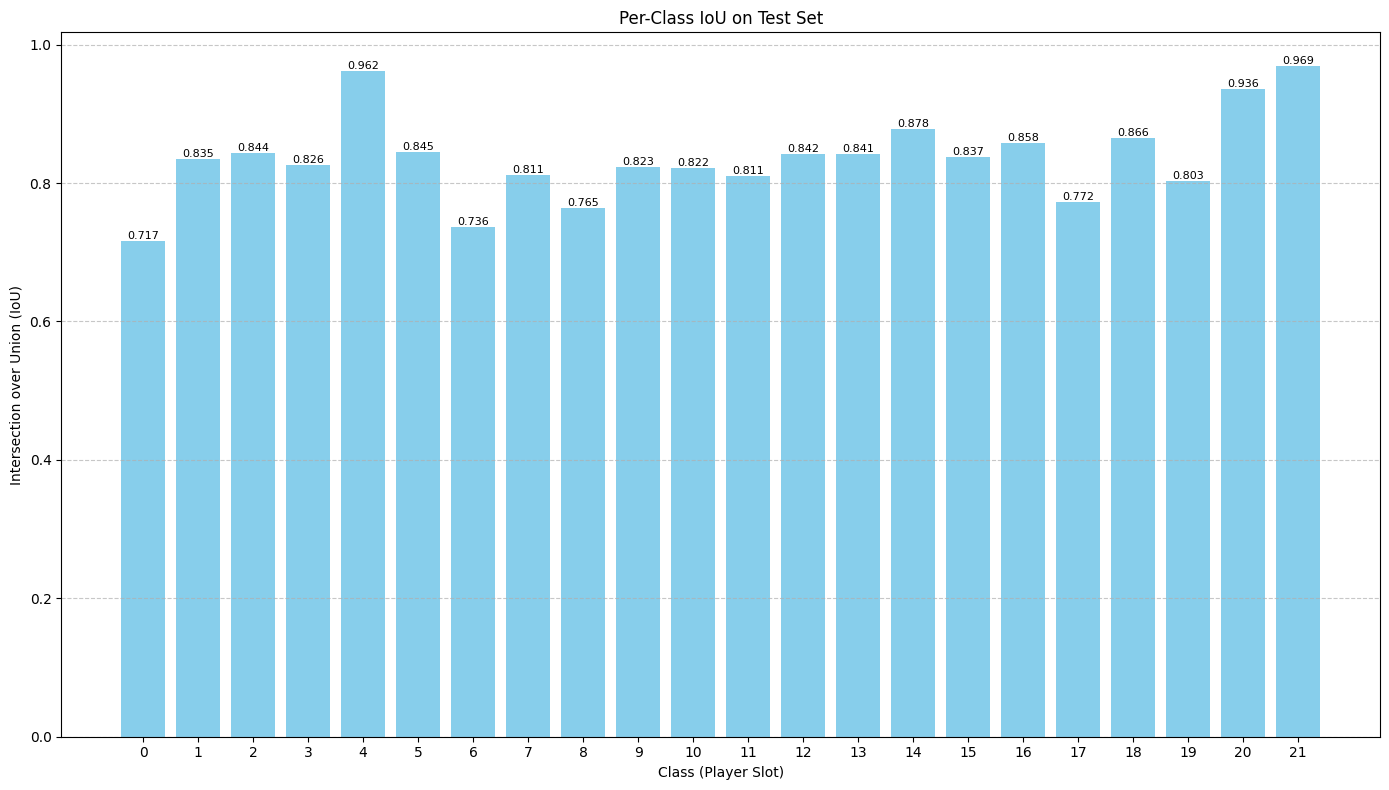

In [85]:
class_iou_data = {
  0: 0.7166,  1: 0.8351,  2: 0.8438,  3: 0.8256,
  4: 0.9618,  5: 0.8445,  6: 0.7358,  7: 0.8110,
  8: 0.7646,  9: 0.8233, 10: 0.8219, 11: 0.8106,
 12: 0.8420, 13: 0.8414, 14: 0.8780, 15: 0.8371,
 16: 0.8584, 17: 0.7720, 18: 0.8658, 19: 0.8026,
 20: 0.9359, 21: 0.9693
}

classes = list(class_iou_data.keys())
iou_values = list(class_iou_data.values())

plt.figure(figsize=(14, 8)) 
bars = plt.bar(classes, iou_values, color='skyblue')

plt.xlabel('Class (Player Slot)')
plt.ylabel('Intersection over Union (IoU)')
plt.title('Per-Class IoU on Test Set')
plt.xticks(classes) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center', fontsize=8) 

plt.tight_layout() 
plt.show()

In [ ]:
import numpy as np
import torch

POS_X_IDX = 0
POS_Y_IDX = 1
VEL_X_IDX = 2
VEL_Y_IDX = 3

# function to get all the player metrics
def calculate_player_metrics_from_test_set(test_data_list, num_players, ignore_index,
                                           pos_x_idx, pos_y_idx, vel_x_idx, vel_y_idx):
    player_stats = {
        p_idx: {
            'gt_areas': [],
            'speeds': []
        } for p_idx in range(num_players)
    }

    for data_sample in test_data_list:
        gt_map = data_sample.y.cpu().numpy()
        context_features = data_sample.x.cpu().numpy()

        for p_idx in range(num_players):
            area = np.sum((gt_map == p_idx) & (gt_map != ignore_index))
            if area > 0:
                player_stats[p_idx]['gt_areas'].append(area)

        for p_idx in range(num_players):
            vx_player = context_features[:, p_idx, vel_x_idx]
            vy_player = context_features[:, p_idx, vel_y_idx]
            speeds_in_context = np.sqrt(vx_player**2 + vy_player**2)
            if len(speeds_in_context) > 0:
                avg_speed_context = np.mean(speeds_in_context)
                player_stats[p_idx]['speeds'].append(avg_speed_context)

    results = {}
    for p_idx in range(num_players):
        gt_areas_player = player_stats[p_idx]['gt_areas']
        speeds_player = player_stats[p_idx]['speeds']

        avg_gt_area = np.mean(gt_areas_player) if gt_areas_player else 0
        std_gt_area = np.std(gt_areas_player) if gt_areas_player else 0
        avg_speed = np.mean(speeds_player) if speeds_player else 0

        results[p_idx] = {
            'avg_gt_area': avg_gt_area,
            'std_gt_area': std_gt_area,
            'avg_speed': avg_speed
        }
    return results

player_characteristic_metrics = calculate_player_metrics_from_test_set(
    test_data_list=test_data,
    num_players=final_num_players_on_field,
    ignore_index=IGNORE_INDEX,
    pos_x_idx=POS_X_IDX,
    pos_y_idx=POS_Y_IDX,
    vel_x_idx=VEL_X_IDX,
    vel_y_idx=VEL_Y_IDX
)

# Correlation tests
per_class_iou_scores = class_iou_data
print("\n--- Correlation Analysis ---")
print(f"{'Player Idx':<12} | {'IoU':<7} | {'Avg GT Area':<12} | {'Std GT Area':<12} | {'Avg Speed':<10}")
print("-" * 70)

iou_values = []
avg_gt_area_values = []
std_gt_area_values = []
avg_speed_values = []

for p_idx in range(final_num_players_on_field):
    iou = per_class_iou_scores[p_idx]
    stats = player_characteristic_metrics[p_idx]

    iou_values.append(iou)
    avg_gt_area_values.append(stats['avg_gt_area'])
    std_gt_area_values.append(stats['std_gt_area'])
    avg_speed_values.append(stats['avg_speed'])

    print(f"{p_idx:<12} | {iou:<7.4f} | {stats['avg_gt_area']:<12.2f} | {stats['std_gt_area']:<12.2f} | {stats['avg_speed']:<10.4f}")

corr_iou_area = np.corrcoef(iou_values, avg_gt_area_values)[0, 1]
print(f"\nCorrelation (IoU vs. Avg GT Area): {corr_iou_area:.4f}")

corr_iou_std_area = np.corrcoef(iou_values, std_gt_area_values)[0, 1]
print(f"Correlation (IoU vs. Std Dev GT Area): {corr_iou_std_area:.4f}")

corr_iou_speed = np.corrcoef(iou_values, avg_speed_values)[0, 1]
print(f"Correlation (IoU vs. Avg Speed): {corr_iou_speed:.4f}")


--- Correlation Analysis ---
Player Idx   | IoU     | Avg GT Area  | Std GT Area  | Avg Speed 
----------------------------------------------------------------------
0            | 0.7166  | 113.44       | 193.92       | 0.8885    
1            | 0.8351  | 238.81       | 186.77       | 0.8889    
2            | 0.8438  | 246.01       | 212.20       | 0.7867    
3            | 0.8256  | 186.59       | 158.58       | 0.7874    
4            | 0.9618  | 896.86       | 940.17       | 0.6350    
5            | 0.8445  | 219.89       | 238.42       | 0.7887    
6            | 0.7358  | 105.23       | 89.46        | 0.8291    
7            | 0.8110  | 179.23       | 182.76       | 0.8243    
8            | 0.7646  | 117.35       | 131.55       | 0.8196    
9            | 0.8233  | 196.10       | 205.11       | 0.7998    
10           | 0.8219  | 200.91       | 169.96       | 0.7634    
11           | 0.8106  | 205.00       | 242.38       | 0.7776    
12           | 0.8420  | 229.03       | 2


--- Average Position per Sorted Index Slot ---
Sorted Idx   | Avg Pos (X, Y)      
-----------------------------------
0            | (52.7, 29.3)        
1            | (47.0, 44.2)        
2            | (63.4, 29.1)        
3            | (42.0, 20.0)        
4            | (20.9, 31.1)        
5            | (65.0, 40.2)        
6            | (55.5, 28.3)        
7            | (54.3, 28.0)        
8            | (50.4, 30.6)        
9            | (62.7, 31.6)        
10           | (70.7, 36.4)        
11           | (61.8, 45.9)        
12           | (42.3, 45.7)        
13           | (42.1, 20.2)        
14           | (65.6, 46.4)        
15           | (48.4, 13.7)        
16           | (48.5, 38.4)        
17           | (45.4, 33.4)        
18           | (36.5, 32.9)        
19           | (54.6, 26.8)        
20           | (69.8, 24.8)        
21           | (90.0, 30.7)        


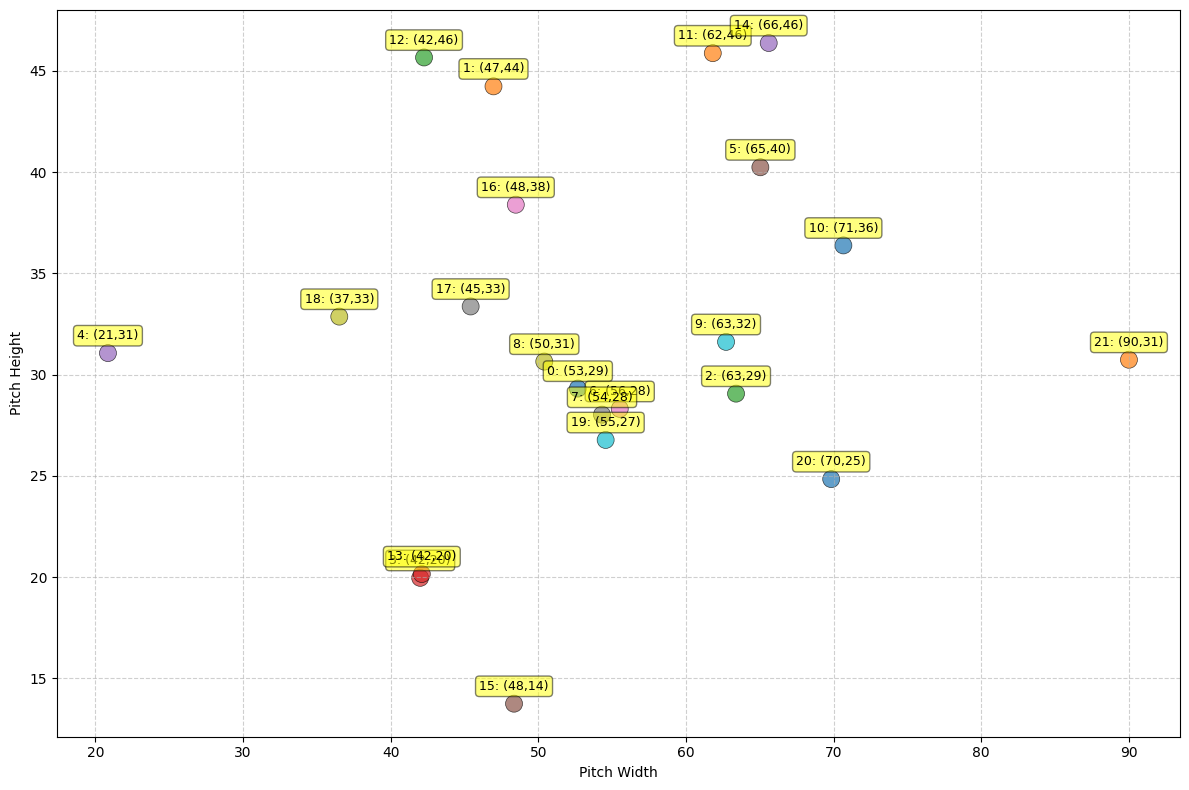

In [ ]:
# CALCULATE AVERAGE POSITION
sorted_index_to_player_id_counts = [Counter() for _ in range(ACTUAL_PLAYERS_PER_FRAME)]
sorted_index_to_player_avg_pos = [defaultdict(lambda: {'x_sum': 0, 'y_sum': 0, 'count': 0}) for _ in range(ACTUAL_PLAYERS_PER_FRAME)]

grouped_by_frame_for_roles = df.groupby('frame')
temp_original_player_ids_per_frame_slot = [[] for _ in range(len(processed_frame_indices))]

for i, original_frame_num in enumerate(processed_frame_indices):
    frame_data = grouped_by_frame_for_roles.get_group(original_frame_num)
    player_data = frame_data[frame_data['player_id'] != 'ball'].copy()
    player_data = player_data.sort_values(by='player_id')
    actual_ids_in_sorted_order = player_data['player_id'].astype(str).tolist()
    temp_original_player_ids_per_frame_slot[i] = actual_ids_in_sorted_order

loop_limit = min(len(temp_original_player_ids_per_frame_slot), len(original_positions))

for frame_idx_processed in range(loop_limit):
    actual_ids_this_frame = temp_original_player_ids_per_frame_slot[frame_idx_processed]
    positions_this_frame = original_positions[frame_idx_processed]

    for sorted_idx in range(ACTUAL_PLAYERS_PER_FRAME):
        actual_player_id = actual_ids_this_frame[sorted_idx]
        pos_x, pos_y = positions_this_frame[sorted_idx]
        sorted_index_to_player_id_counts[sorted_idx][actual_player_id] += 1
        sorted_index_to_player_avg_pos[sorted_idx][actual_player_id]['x_sum'] += pos_x
        sorted_index_to_player_avg_pos[sorted_idx][actual_player_id]['y_sum'] += pos_y
        sorted_index_to_player_avg_pos[sorted_idx][actual_player_id]['count'] += 1

# print and plot results
print("\n--- Average Position per Sorted Index Slot ---")
print(f"{'Sorted Idx':<12} | {'Avg Pos (X, Y)':<20}")
print("-" * 35)

plot_points_x = []
plot_points_y = []
plot_point_annotations = []
plot_point_colors = []
tableau_colors = list(mcolors.TABLEAU_COLORS.values())

for sorted_idx in range(ACTUAL_PLAYERS_PER_FRAME):
    most_common_pid_info = sorted_index_to_player_id_counts[sorted_idx].most_common(1)
    most_common_pid = most_common_pid_info[0][0]
    pos_data = sorted_index_to_player_avg_pos[sorted_idx][most_common_pid]
    avg_x_slot = pos_data['x_sum'] / pos_data['count']
    avg_y_slot = pos_data['y_sum'] / pos_data['count']

    plot_points_x.append(avg_x_slot)
    plot_points_y.append(avg_y_slot)
    annotation_text = f"{sorted_idx}: ({avg_x_slot:.0f},{avg_y_slot:.0f})"
    plot_point_annotations.append(annotation_text)
    plot_point_colors.append(tableau_colors[sorted_idx % len(tableau_colors)])
    avg_pos_str = f"({avg_x_slot:.1f}, {avg_y_slot:.1f})"

    print(f"{sorted_idx:<12} | {avg_pos_str:<20}")

plt.figure(figsize=(12, 8))
plt.scatter(plot_points_x, plot_points_y, c=plot_point_colors, s=150, alpha=0.7, edgecolors="k", linewidth=0.5)

for i, annotation_text in enumerate(plot_point_annotations):
    plt.annotate(annotation_text,
                 (plot_points_x[i], plot_points_y[i]),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5, ec='black'))

plt.xlabel('Pitch Width')
plt.ylabel('Pitch Height')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


RUNNING TEST 1...

--- Test 1: Positional Sensitivity (Player 0) ---
  mIoU for this plot (vs own GT): 0.7775


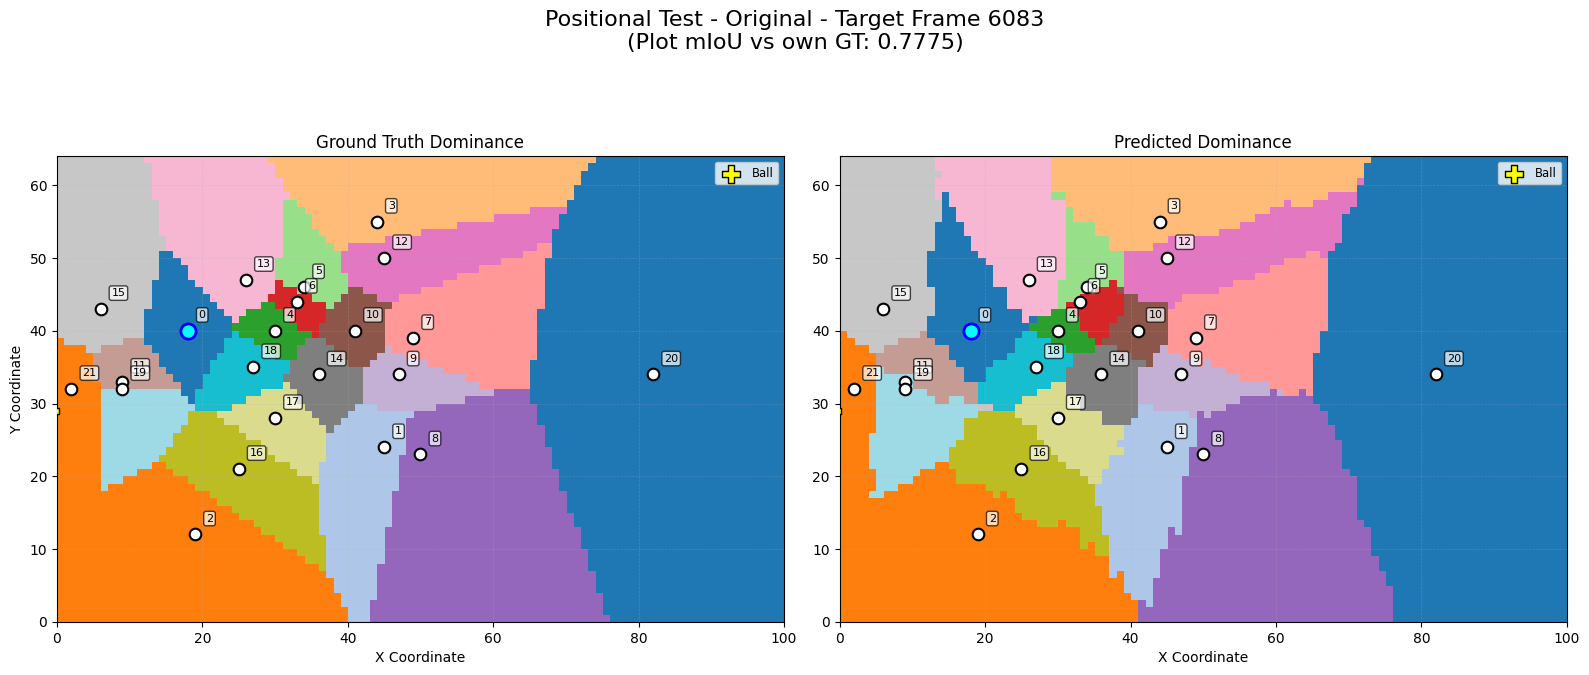

Prediction After Moving Player 0 by (1.0, 0.0):
  mIoU for this plot (vs own GT): 0.7708


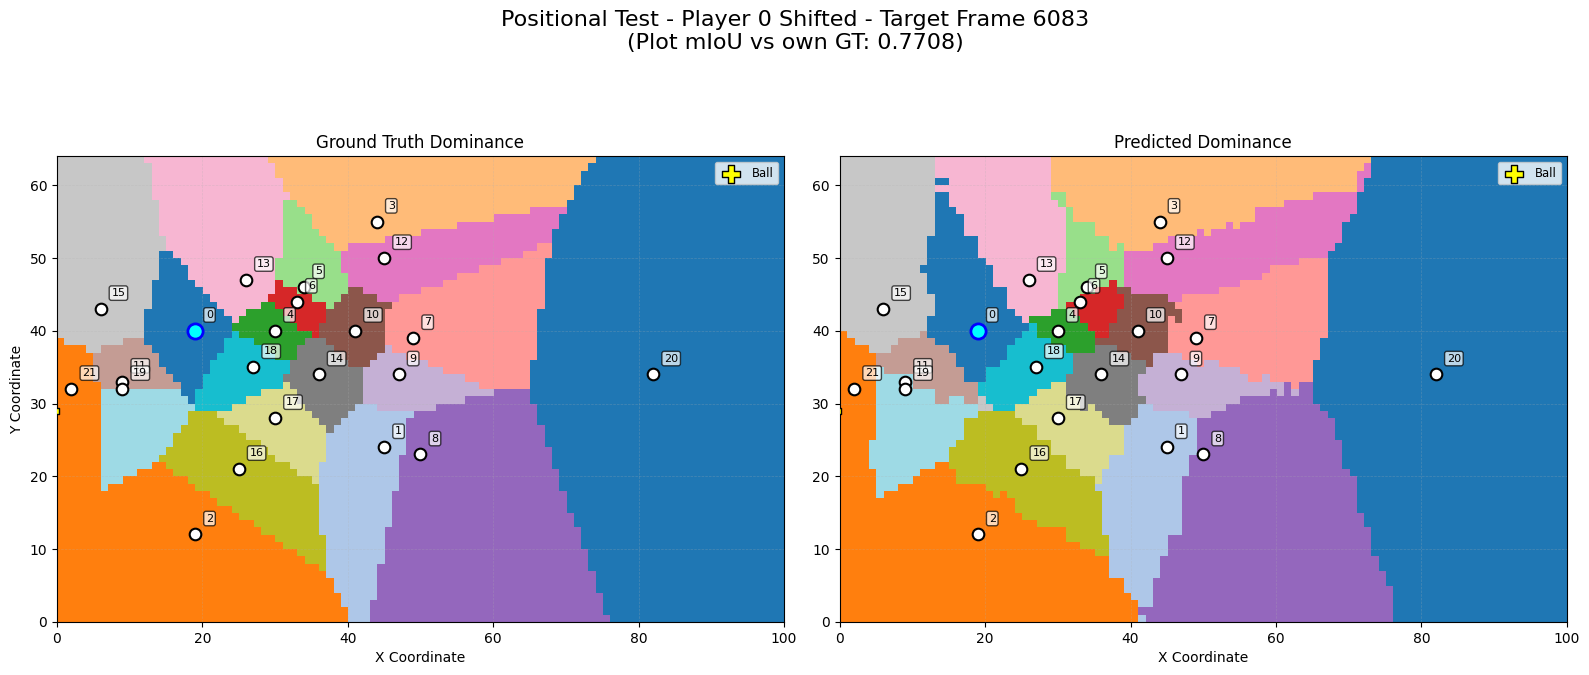


RUNNING TEST 2...

--- Test 2: Velocity Sensitivity (Player 0) ---
  mIoU for this plot (vs own GT): 0.7775


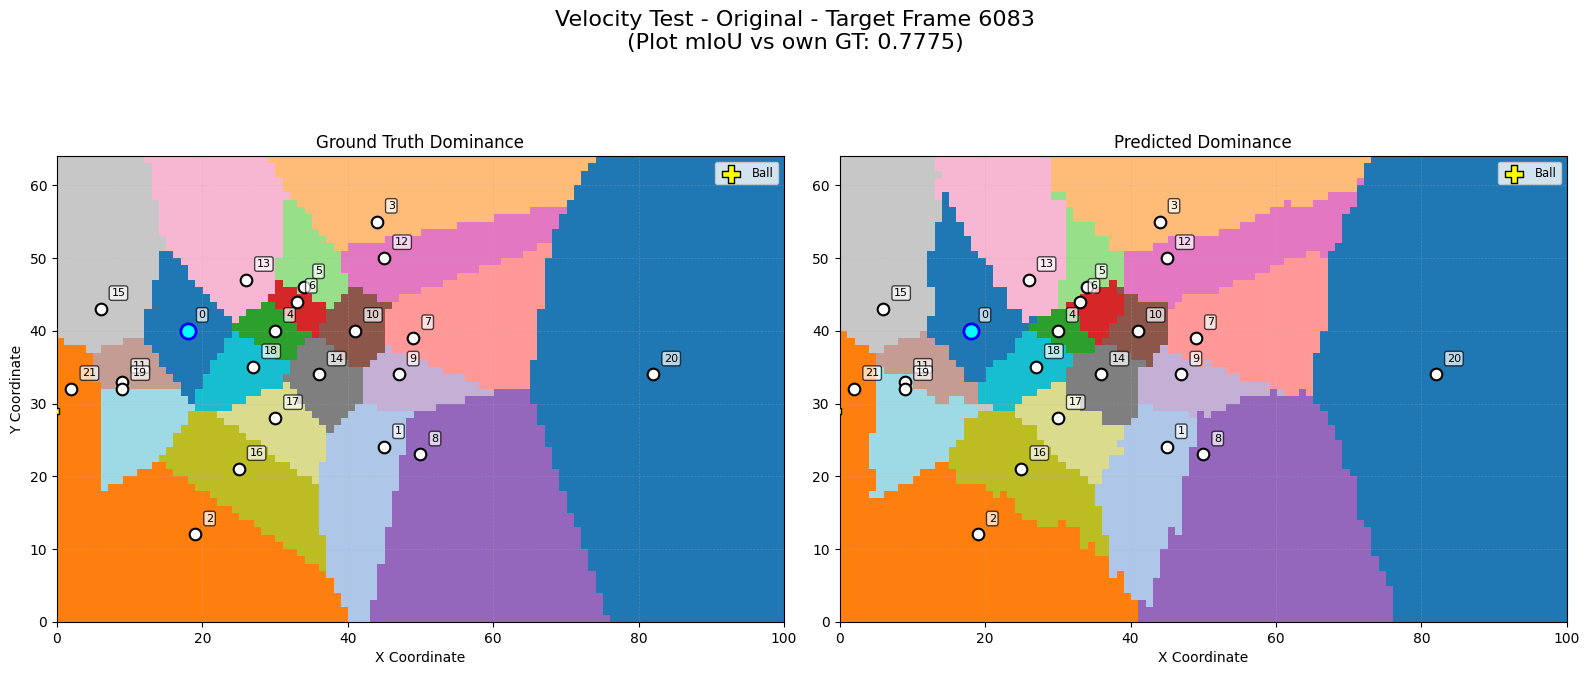

Prediction After Changing Player 0's Velocity to (0.00, 20.00) for last 20 context frames:
  mIoU for this plot (vs own GT): 0.7312


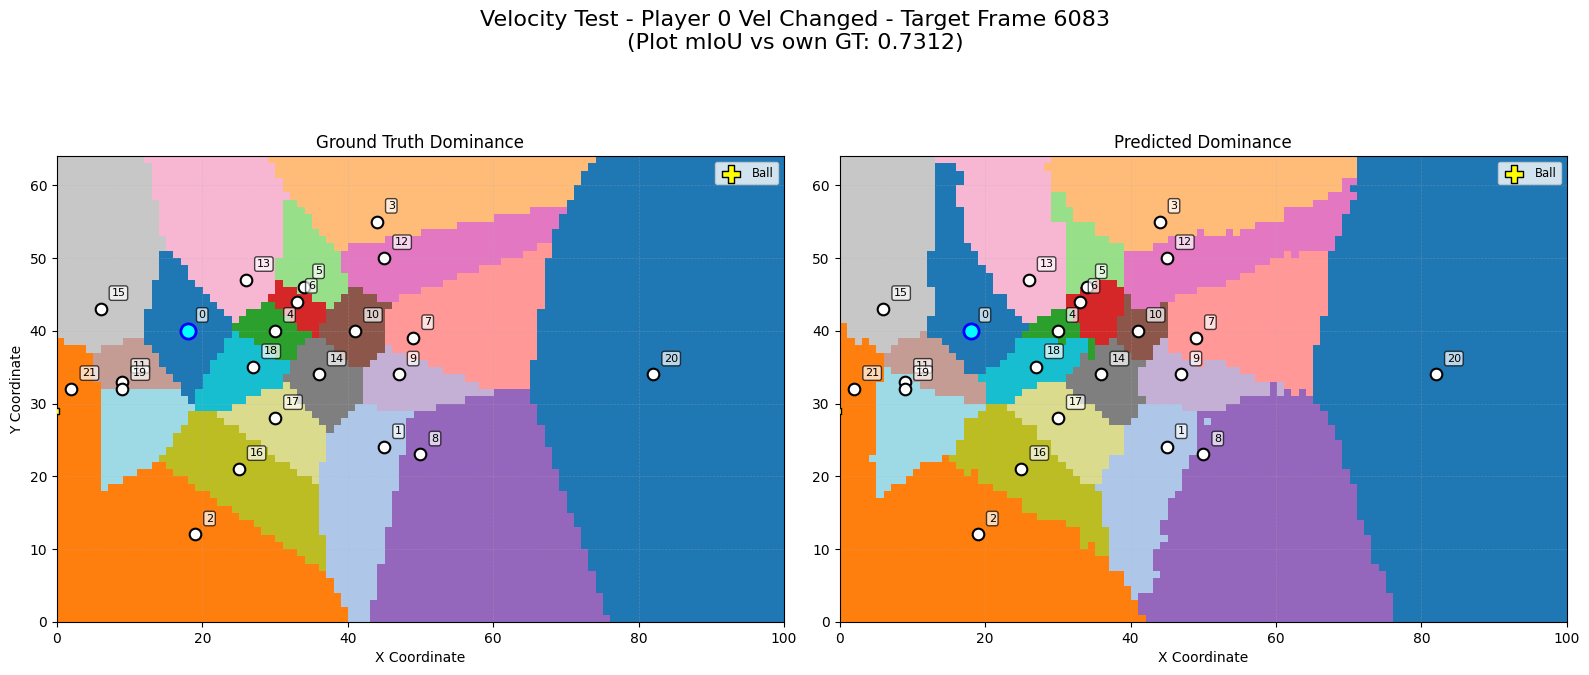


RUNNING TEST 3...

--- Test 3: Ball Proximity Sensitivity (Player 0) ---
  mIoU for this plot (vs own GT): 0.7775


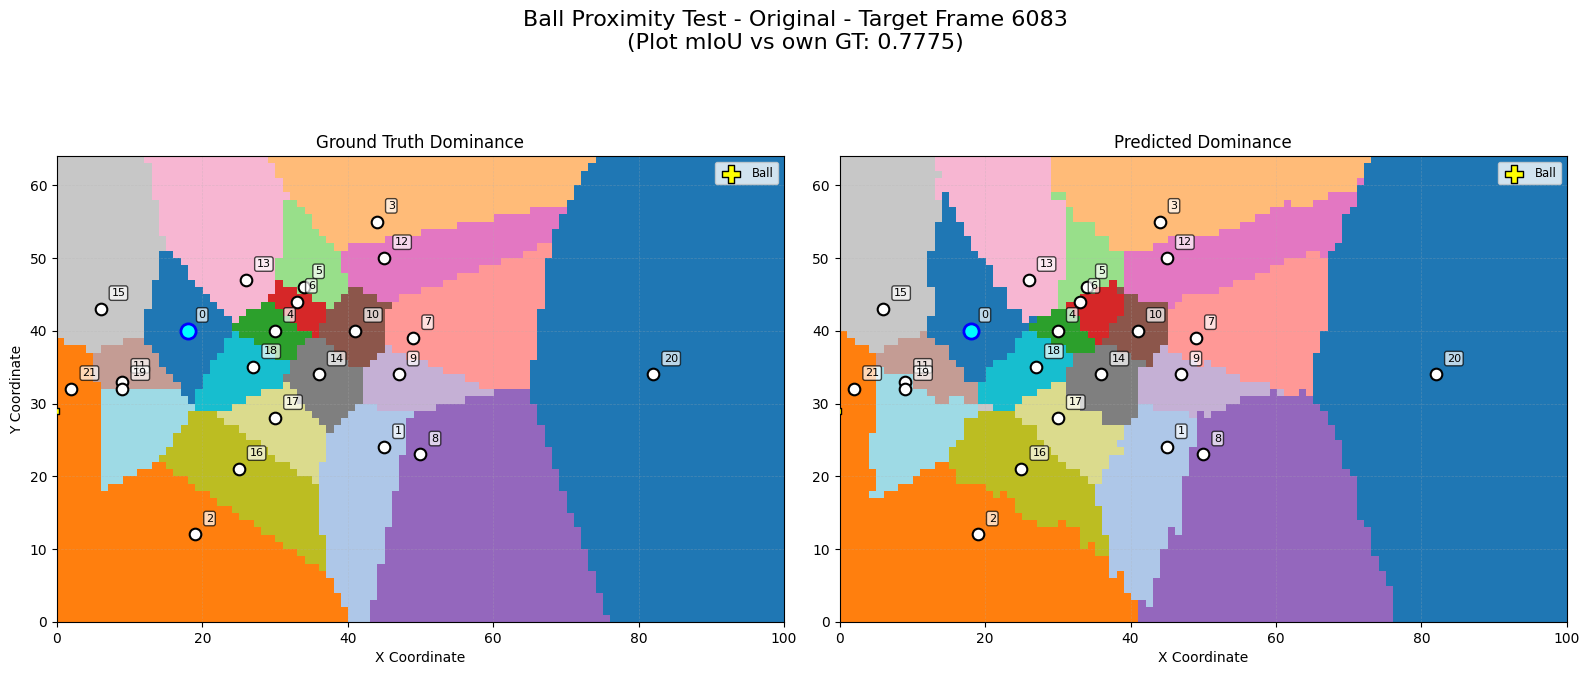

Prediction After Simulating Ball at Relative Pos (20.0, 0.0) to Player 0:
  mIoU for this plot (vs own GT): 0.0893


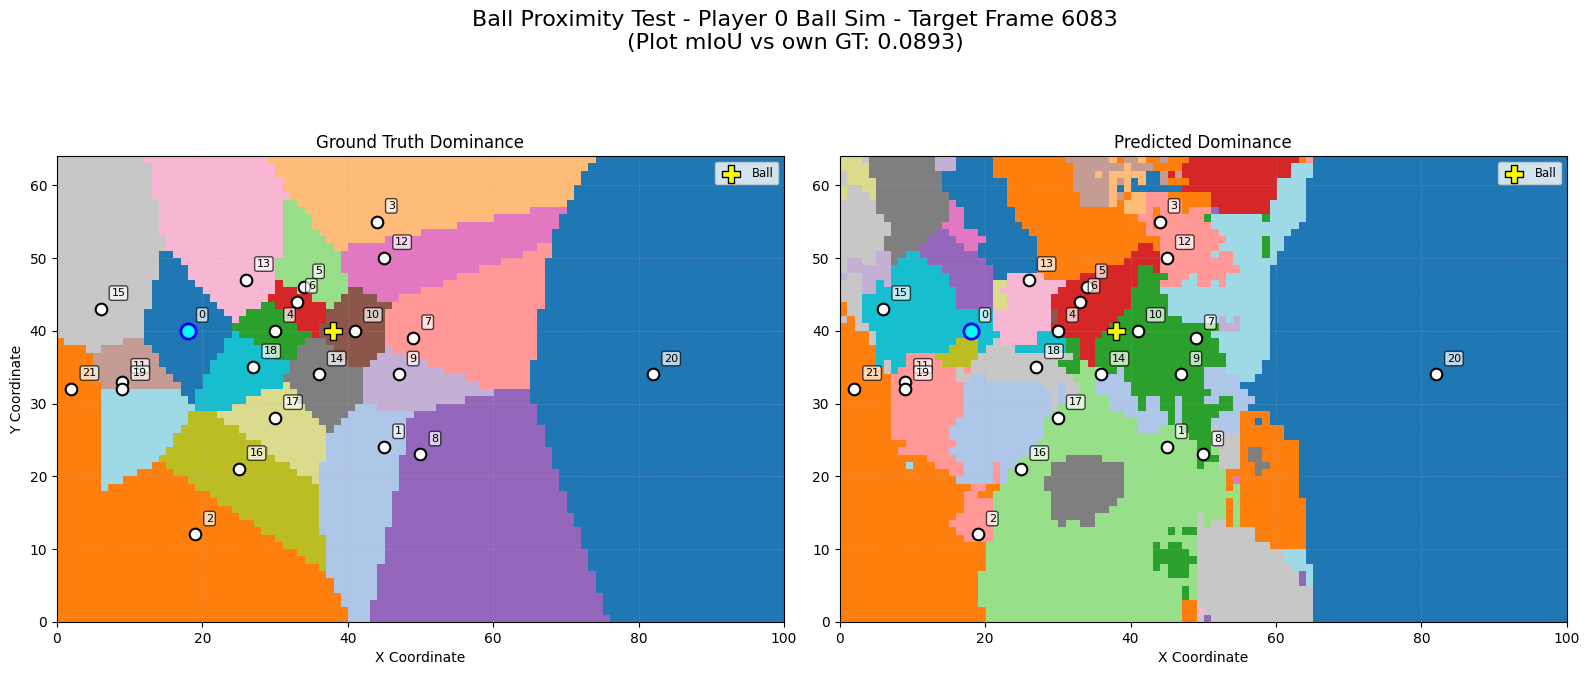


RUNNING TEST 4...

--- Test 4: Player Identity Swap (On-field Player 0 <-> 10) ---
  mIoU for this plot (vs own GT): 0.7775


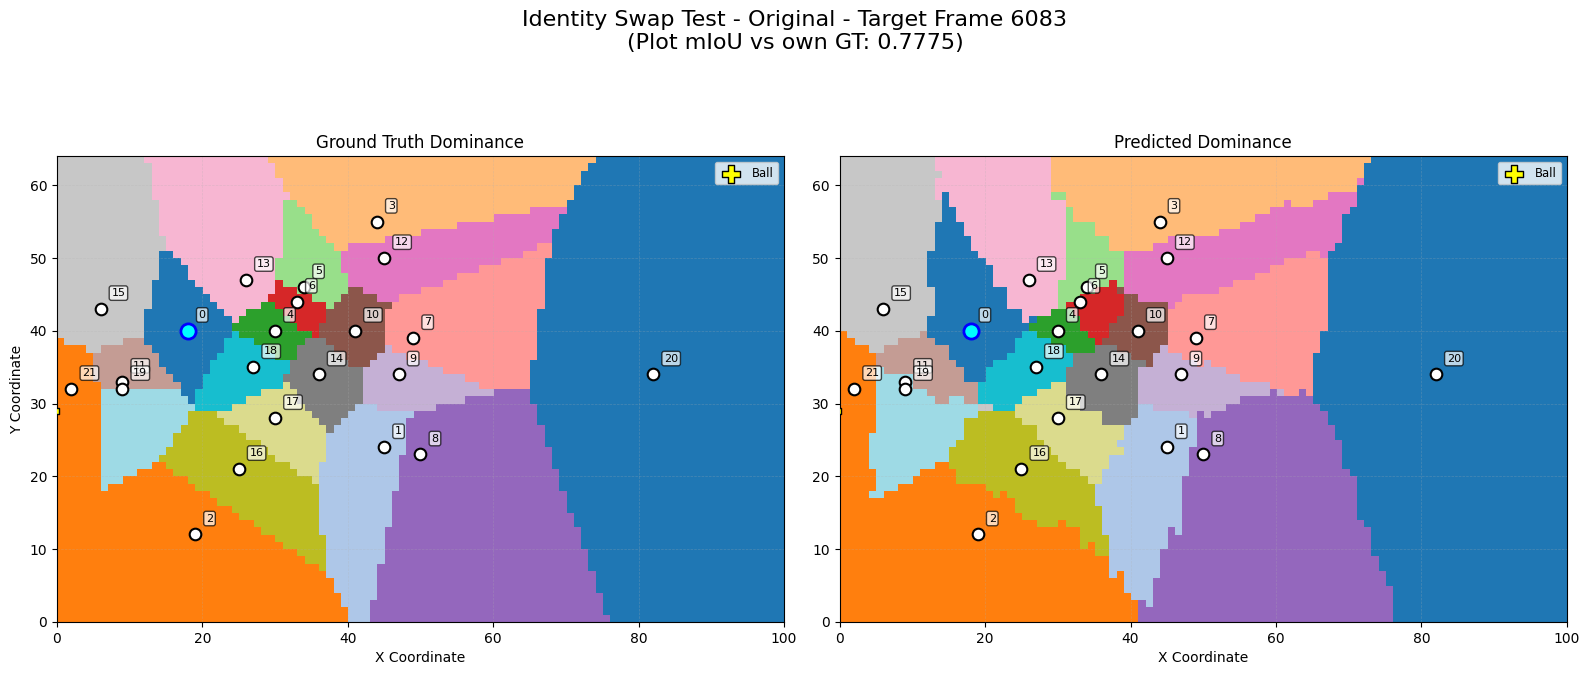

  Swapping unique IDs: On-field 0 (was ID 22) with On-field 10 (was ID 6)
Prediction After Swapping Identities of On-field Player Index 0 and 10:
  mIoU for this plot (vs own GT): 0.7751


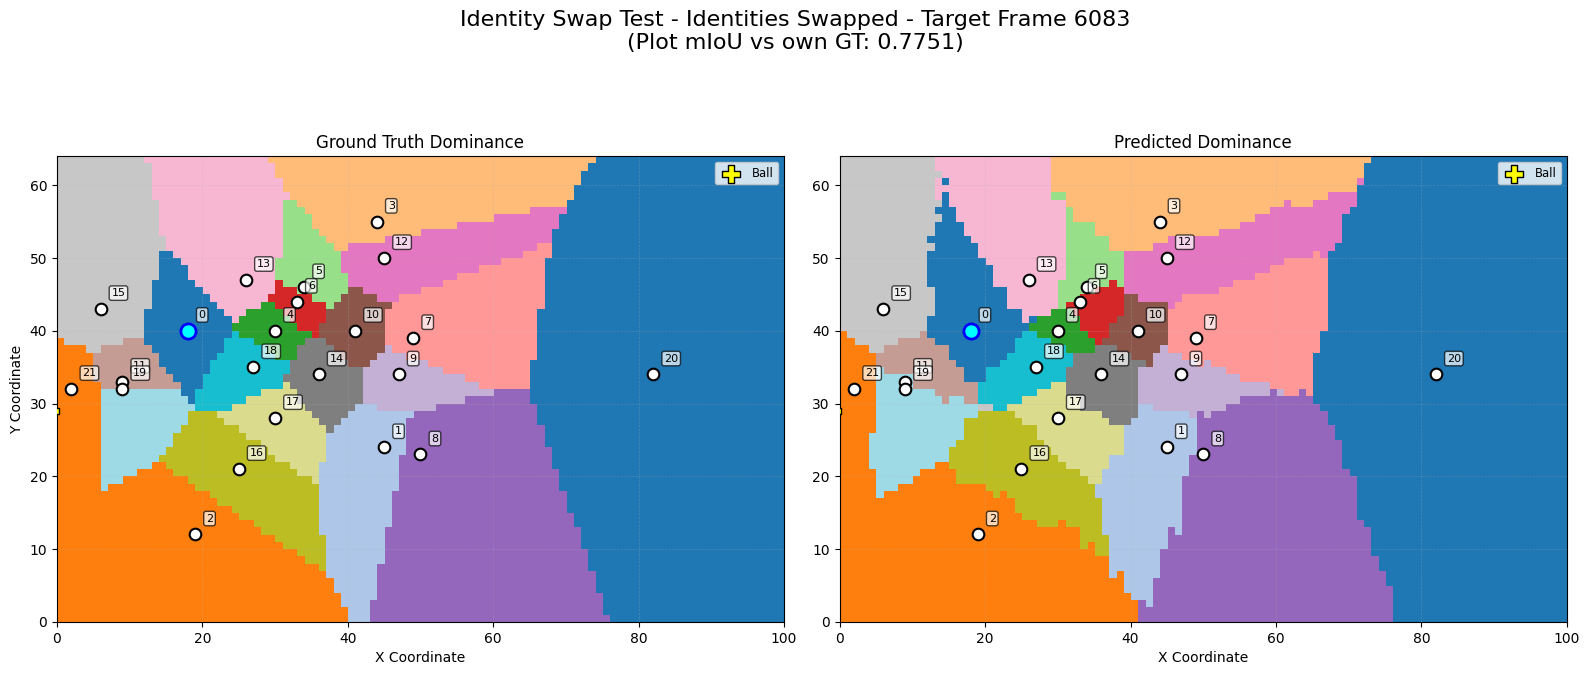


RUNNING TEST 5...

--- Test 5: Team Affiliation Swap (Player 0) ---
  mIoU for this plot (vs own GT): 0.7775


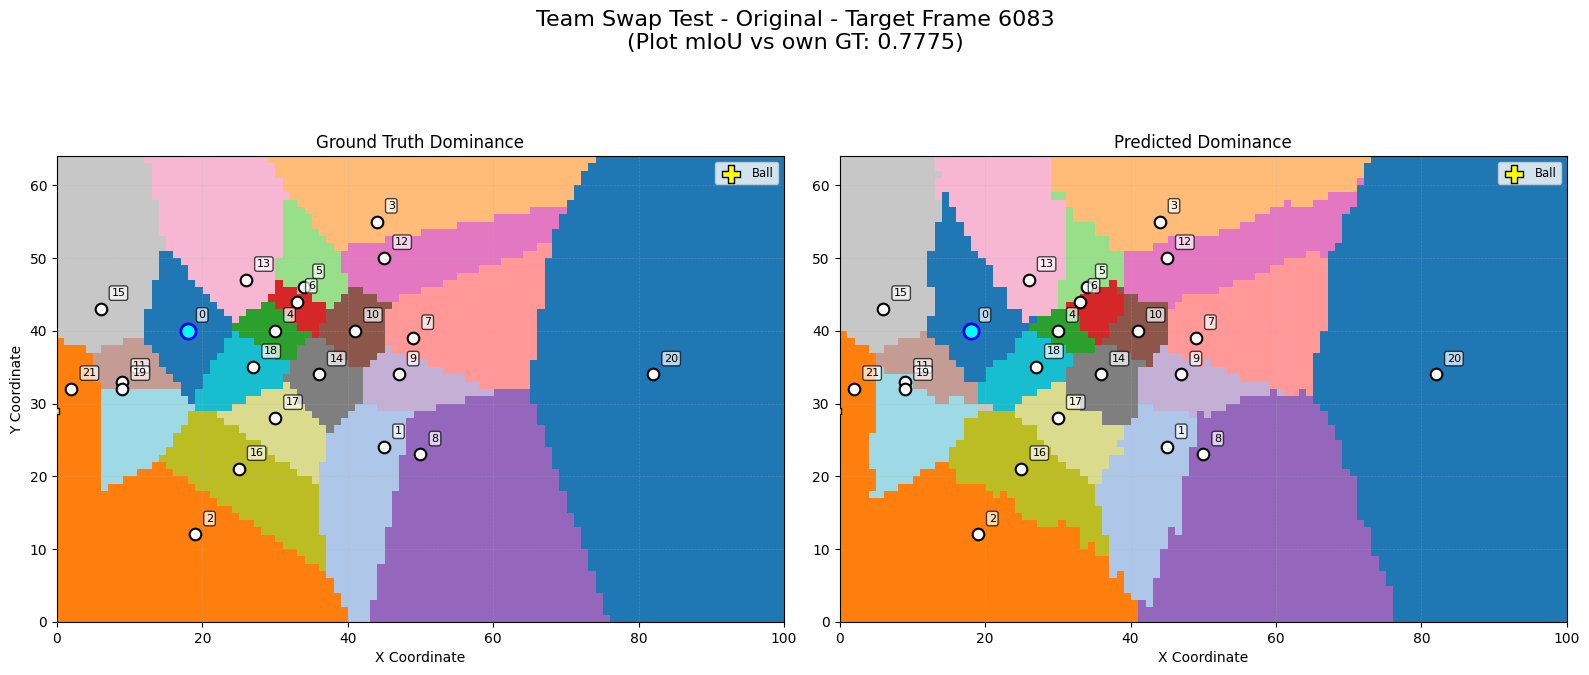

  Changed team for on-field player 0 from -1.0 to 0.0
Prediction After Swapping Team for On-field Player 0:
  mIoU for this plot (vs own GT): 0.7689


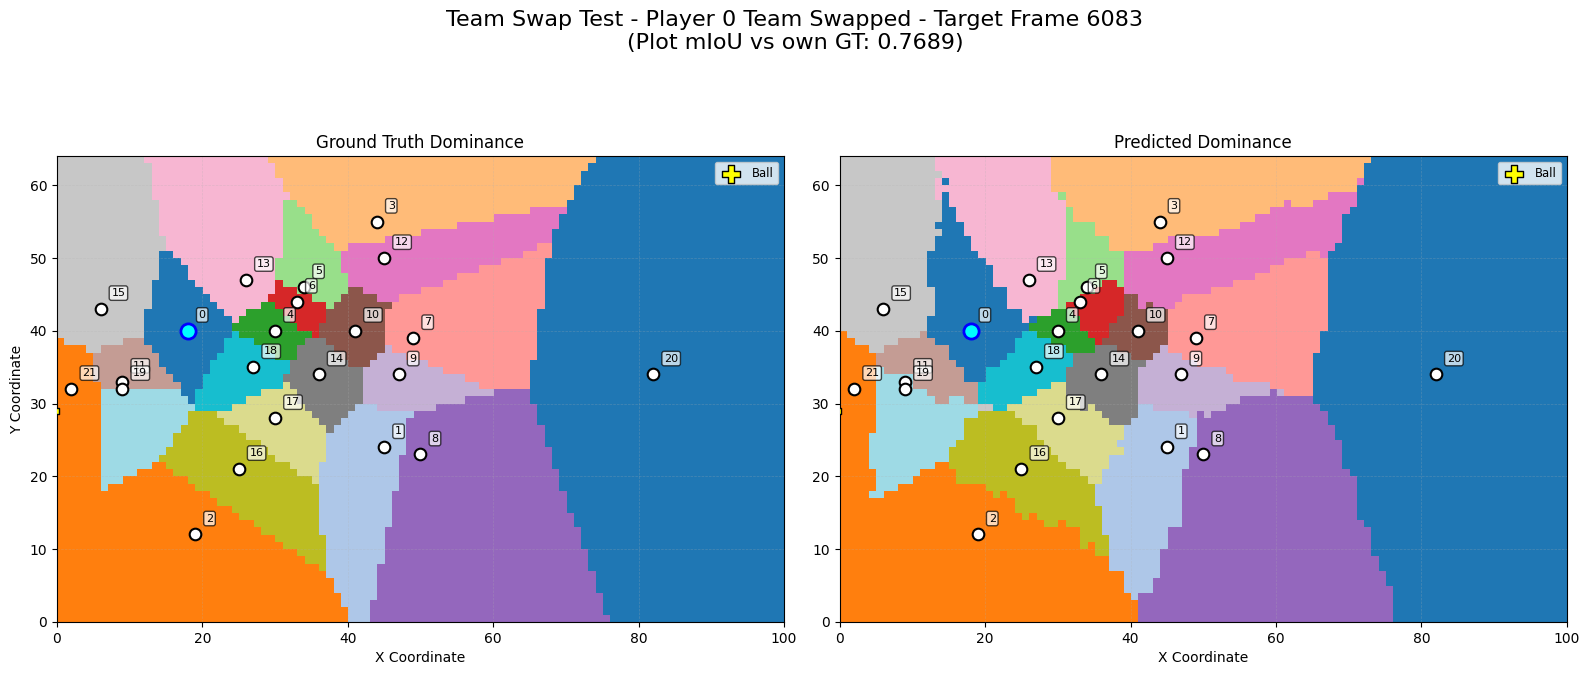


RUNNING TEST 6...
  Using context start index for Test 6: 6039

--- Test 6: Temporal Consistency Check ---
Prediction for context ending at frame index 6068 (predicting target index 6083):
  mIoU for this plot (vs own GT): 0.7775


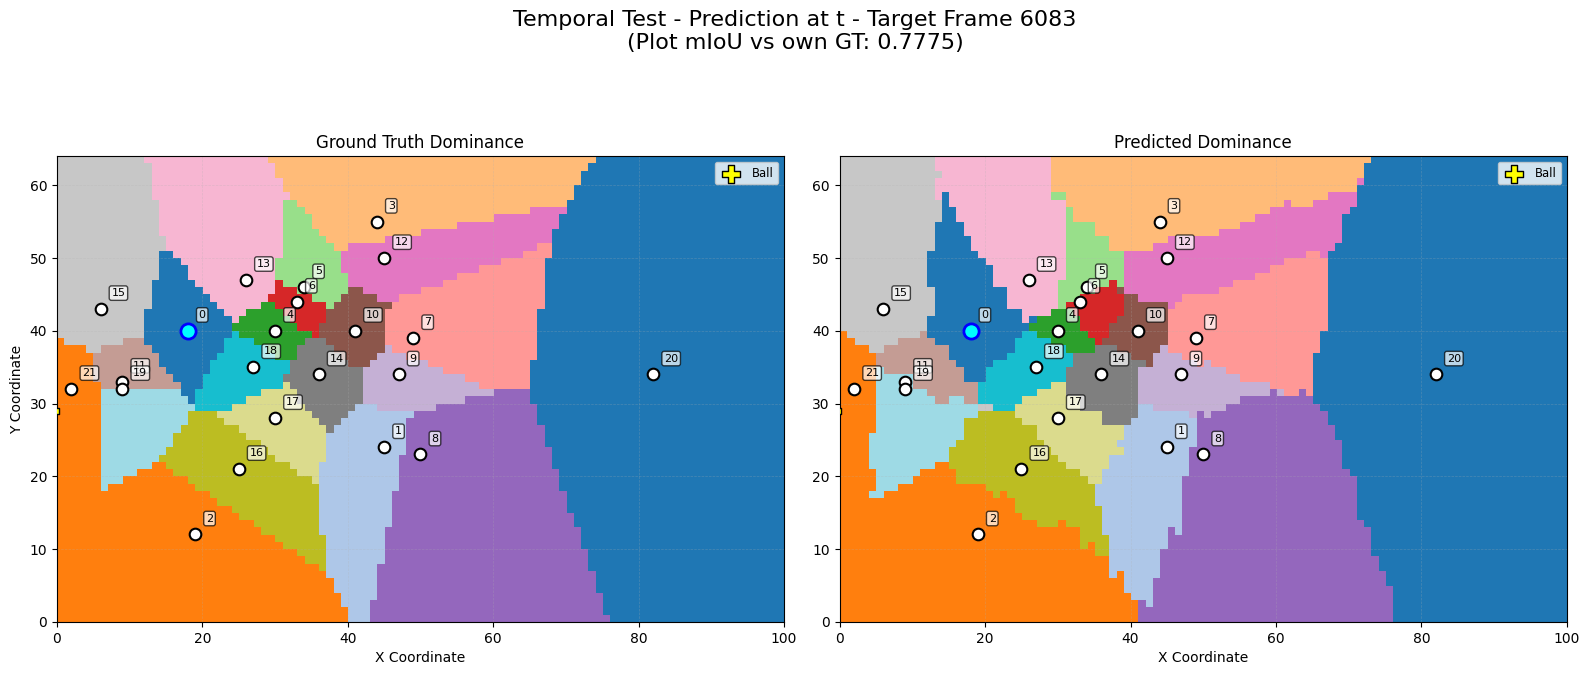

Prediction for context ending at frame index 6069 (predicting target index 6084):
  mIoU for this plot (vs own GT): 0.7920


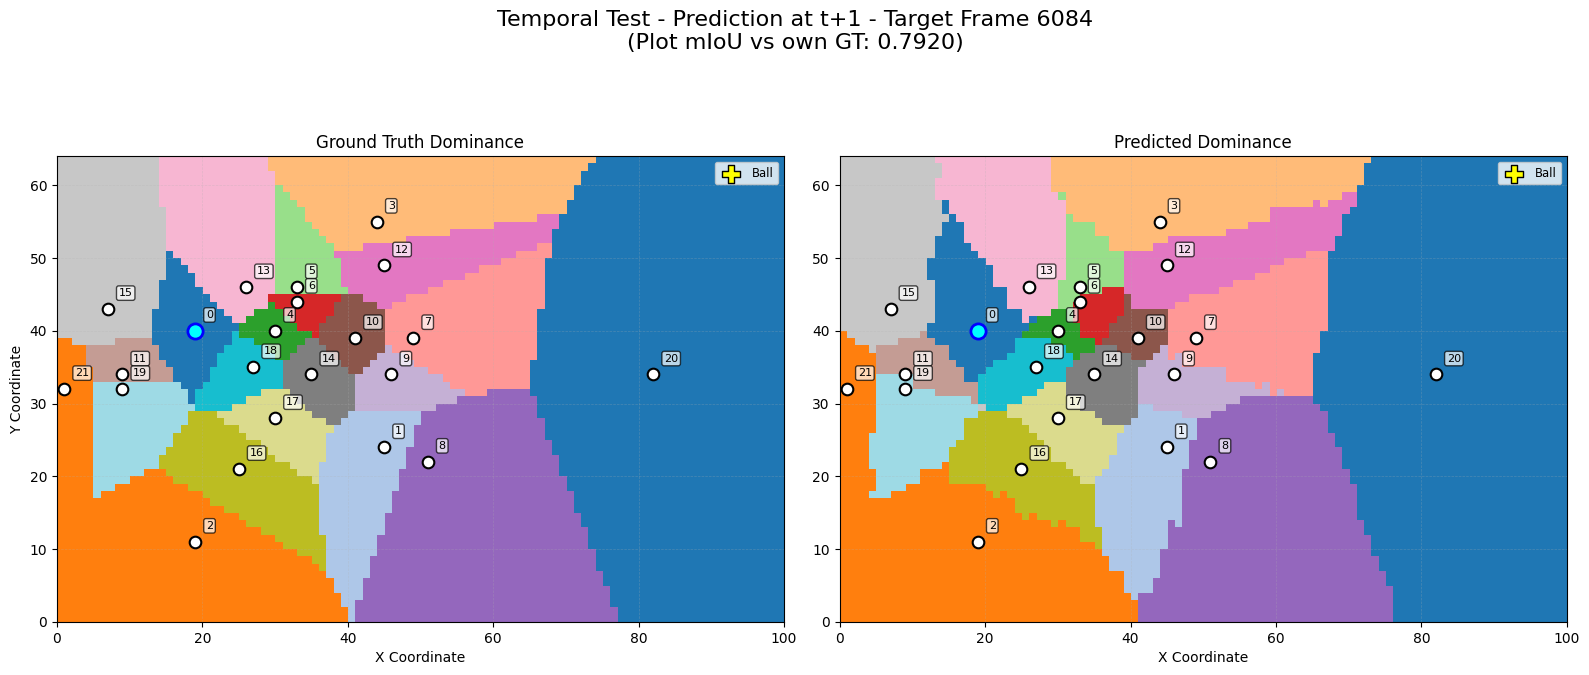

In [ ]:
# function to calculate iou per frame
def calculate_iou(pred_logits_iou, targets_iou, num_classes_iou, ignore_index_iou):
    preds_iou = torch.argmax(pred_logits_iou, dim=1)
    batch_size_iou = preds_iou.shape[0]
    batch_iou_per_class_iou = []
    batch_mean_iou_iou = []
    for i in range(batch_size_iou):
        pred_single_iou = preds_iou[i]
        target_single_iou = targets_iou[i]
        iou_list_sample_iou = []
        present_class_count_iou = 0
        valid_mask_iou = (target_single_iou != ignore_index_iou)
        for c in range(num_classes_iou):
            pred_mask_c_iou = (pred_single_iou == c) & valid_mask_iou
            target_mask_c_iou = (target_single_iou == c) & valid_mask_iou
            intersection_iou = (pred_mask_c_iou & target_mask_c_iou).sum().float()
            union_iou = (pred_mask_c_iou | target_mask_c_iou).sum().float()
            iou_val = 0.0
            if union_iou > 0:
                iou_tensor_iou = intersection_iou / union_iou
                iou_val = iou_tensor_iou.item()
                present_class_count_iou += 1
            iou_list_sample_iou.append(iou_val)
        batch_iou_per_class_iou.append(iou_list_sample_iou)
        sum_iou_sample_iou = sum(iou_list_sample_iou)
        mean_iou_sample_val = 0.0
        if present_class_count_iou > 0:
             mean_iou_sample_val = sum_iou_sample_iou / present_class_count_iou
        batch_mean_iou_iou.append(mean_iou_sample_val)
    return batch_iou_per_class_iou, batch_mean_iou_iou

# to predict the space domaince
def get_prediction_outputs(model, data_sample, device):
    model.eval()
    with torch.no_grad():
        data_on_device = data_sample.to(device)
        pred_logits = model(data_on_device)
        predicted_map_np = torch.argmax(pred_logits, dim=1).squeeze().cpu().numpy()
    return pred_logits, predicted_map_np

# plotting
def plot_dominance_for_sensitivity(
    data_sample_to_plot,
    pred_logits_for_iou,
    predicted_map_np,
    original_positions_all_for_target_frame_viz,
    grid_shape,
    num_players,
    ignore_index_val,
    device_val,
    title_prefix="",
    title_suffix="",
    highlight_player_idx=0 
    ):
    GRID_W_plot, GRID_H_plot = grid_shape
    ground_truth_map_np = data_sample_to_plot.y.cpu().numpy()
    ground_truth_map_tensor_for_iou = data_sample_to_plot.y.unsqueeze(0).to(device_val)

    _, batch_miou = calculate_iou(
        pred_logits_for_iou,
        ground_truth_map_tensor_for_iou,
        num_players,
        ignore_index_val
    )
    current_plot_miou = batch_miou[0] if batch_miou else 0.0
    print(f"  mIoU for this plot (vs own GT): {current_plot_miou:.4f}")

    player_pos_target_frame = original_positions_all_for_target_frame_viz.cpu().numpy()
    ball_pos_target_frame = data_sample_to_plot.ball_pos.cpu().numpy()

    cmap_tab20 = plt.get_cmap('tab20')
    cmap_tab10 = plt.get_cmap('tab10')
    cmap_colors_n = list(cmap_tab20.colors) + list(cmap_tab10.colors[:max(0, num_players-20)])
    cmap_colors_n = cmap_colors_n[:num_players]
    plot_cmap_n = mcolors.ListedColormap(cmap_colors_n)

    boundaries = np.arange(num_players + 1) - 0.5
    norm = mcolors.BoundaryNorm(boundaries, plot_cmap_n.N)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    target_frame_display_idx = data_sample_to_plot.target_idx if hasattr(data_sample_to_plot, 'target_idx') else 'Unknown'
    fig.suptitle(f'{title_prefix} - Target Frame {target_frame_display_idx}{title_suffix}\n(Plot mIoU vs own GT: {current_plot_miou:.4f})', fontsize=16)

    def plot_entities(ax, players_pos, ball_pos_entities, highlight_idx): 
        if players_pos is not None:
            for p_idx in range(players_pos.shape[0]):
                px, py = players_pos[p_idx]
                marker_size = 70
                face_color = 'white'
                edge_color = 'black'
                z_order = 10
                line_width = 1.5

                if p_idx == highlight_idx:
                    marker_size = 120  
                    face_color = 'cyan' 
                    edge_color = 'blue'
                    z_order = 11      
                    line_width = 2.0

                ax.scatter(px, py, marker='o', s=marker_size, facecolors=face_color,
                           edgecolors=edge_color, linewidth=line_width, zorder=z_order)
                ax.text(px + 1.5, py + 1.5, str(p_idx), color='black', fontsize=8, ha='left', va='bottom',
                        bbox=dict(facecolor='white', alpha=0.7, pad=0.1, boxstyle='round,pad=0.2'), zorder=z_order+1) 
                
            ax.scatter(ball_pos_entities[0], ball_pos_entities[1], marker='P', s=180, c='yellow', edgecolors='black', linewidths=1.0, zorder=12, label="Ball")
            ax.legend(loc='upper right', fontsize='small')


    actual_labels_masked = np.ma.masked_where(ground_truth_map_np == ignore_index_val, ground_truth_map_np)
    im0 = axes[0].imshow(actual_labels_masked, cmap=plot_cmap_n, norm=norm, origin='lower',
                         extent=[0, GRID_W_plot, 0, GRID_H_plot], interpolation='nearest')
    axes[0].set_title('Ground Truth Dominance')
    axes[0].set_xlabel('X Coordinate'); axes[0].set_ylabel('Y Coordinate')
    axes[0].set_xlim(0, GRID_W_plot); axes[0].set_ylim(0, GRID_H_plot)
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
    plot_entities(axes[0], player_pos_target_frame, ball_pos_target_frame, highlight_player_idx) 

    pred_labels_masked = np.ma.masked_where(predicted_map_np == ignore_index_val, predicted_map_np)
    im1 = axes[1].imshow(pred_labels_masked, cmap=plot_cmap_n, norm=norm, origin='lower',
                         extent=[0, GRID_W_plot, 0, GRID_H_plot], interpolation='nearest')
    axes[1].set_title('Predicted Dominance')
    axes[1].set_xlabel('X Coordinate')
    axes[1].set_xlim(0, GRID_W_plot); axes[1].set_ylim(0, GRID_H_plot)
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
    plot_entities(axes[1], player_pos_target_frame, ball_pos_target_frame, highlight_player_idx) 

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

# TEST 1
def test_positional_sensitivity(model, data_sample_original, player_to_perturb,
                                delta_x, delta_y, device,
                                plot_sensitivity_fn,
                                original_positions_all, grid_shape, num_players, ignore_idx_plot):
    print(f"\n--- Test 1: Positional Sensitivity (Player {player_to_perturb}) ---")
    pred_logits_original, pred_original_np = get_prediction_outputs(model, data_sample_original, device)
    target_idx_original = data_sample_original.target_idx
    plot_sensitivity_fn(data_sample_original, pred_logits_original, pred_original_np,
                        original_positions_all[target_idx_original],
                        grid_shape, num_players, ignore_idx_plot, device,
                        title_prefix="Positional Test - Original")
    data_sample_modified = copy.deepcopy(data_sample_original)
    data_sample_modified.x[:, player_to_perturb, 0] += delta_x
    data_sample_modified.x[:, player_to_perturb, 1] += delta_y
    pred_logits_modified, pred_modified_np = get_prediction_outputs(model, data_sample_modified, device)
    target_idx_modified = data_sample_modified.target_idx
    original_pos_for_modified_plot = original_positions_all[target_idx_modified].clone()
    original_pos_for_modified_plot[player_to_perturb, 0] += delta_x
    original_pos_for_modified_plot[player_to_perturb, 1] += delta_y
    print(f"Prediction After Moving Player {player_to_perturb} by ({delta_x}, {delta_y}):")
    plot_sensitivity_fn(data_sample_modified, pred_logits_modified, pred_modified_np,
                        original_pos_for_modified_plot,
                        grid_shape, num_players, ignore_idx_plot, device,
                        title_prefix=f"Positional Test - Player {player_to_perturb} Shifted")

# TEST 2
def test_velocity_sensitivity(model, data_sample_original, player_to_perturb,
                              new_vx, new_vy, frames_to_change_vel, device,
                              plot_sensitivity_fn,
                              original_positions_all, grid_shape, num_players, ignore_idx_plot):
    print(f"\n--- Test 2: Velocity Sensitivity (Player {player_to_perturb}) ---")
    pred_logits_original, pred_original_np = get_prediction_outputs(model, data_sample_original, device)
    target_idx_original = data_sample_original.target_idx
    plot_sensitivity_fn(data_sample_original, pred_logits_original, pred_original_np,
                        original_positions_all[target_idx_original],
                        grid_shape, num_players, ignore_idx_plot, device,
                        title_prefix="Velocity Test - Original")
    data_sample_modified = copy.deepcopy(data_sample_original)
    context_len = data_sample_modified.x.shape[0]
    start_change_idx = max(0, context_len - frames_to_change_vel)
    data_sample_modified.x[start_change_idx:, player_to_perturb, 2] = new_vx
    data_sample_modified.x[start_change_idx:, player_to_perturb, 3] = new_vy
    pred_logits_modified, pred_modified_np = get_prediction_outputs(model, data_sample_modified, device)
    target_idx_modified = data_sample_modified.target_idx
    print(f"Prediction After Changing Player {player_to_perturb}'s Velocity to ({new_vx:.2f}, {new_vy:.2f}) for last {frames_to_change_vel} context frames:")
    plot_sensitivity_fn(data_sample_modified, pred_logits_modified, pred_modified_np,
                        original_positions_all[target_idx_modified],
                        grid_shape, num_players, ignore_idx_plot, device,
                        title_prefix=f"Velocity Test - Player {player_to_perturb} Vel Changed")

# TEST 3
def test_ball_proximity_sensitivity(model, data_sample_original, player_to_perturb,
                                    simulated_ball_pos_relative_to_player, device,
                                    plot_sensitivity_fn,
                                    original_positions_all, grid_shape, num_players, ignore_idx_plot):
    print(f"\n--- Test 3: Ball Proximity Sensitivity (Player {player_to_perturb}) ---")
    pred_logits_original, pred_original_np = get_prediction_outputs(model, data_sample_original, device)
    target_idx_original = data_sample_original.target_idx
    plot_sensitivity_fn(data_sample_original, pred_logits_original, pred_original_np,
                        original_positions_all[target_idx_original],
                        grid_shape, num_players, ignore_idx_plot, device,
                        title_prefix="Ball Proximity Test - Original")
    data_sample_modified = copy.deepcopy(data_sample_original)
    if hasattr(data_sample_modified, 'ball_pos'):
        data_sample_modified._original_ball_pos_for_plotting = data_sample_modified.ball_pos.clone()
    for t_ctx in range(data_sample_modified.x.shape[0]): 
        data_sample_modified.x[t_ctx, player_to_perturb, 5] = np.sqrt(simulated_ball_pos_relative_to_player[0]**2 + simulated_ball_pos_relative_to_player[1]**2) 
        data_sample_modified.x[t_ctx, player_to_perturb, 6] = -simulated_ball_pos_relative_to_player[0] 
        data_sample_modified.x[t_ctx, player_to_perturb, 7] = -simulated_ball_pos_relative_to_player[1] 
    player_pos_at_target = original_positions_all[data_sample_original.target_idx, player_to_perturb, 0:2] 
    sim_abs_ball_x_target = player_pos_at_target[0] + simulated_ball_pos_relative_to_player[0]
    sim_abs_ball_y_target = player_pos_at_target[1] + simulated_ball_pos_relative_to_player[1]
    data_sample_modified.ball_pos = torch.tensor([sim_abs_ball_x_target, sim_abs_ball_y_target], dtype=torch.float)
    pred_logits_modified, pred_modified_np = get_prediction_outputs(model, data_sample_modified, device)
    target_idx_modified = data_sample_modified.target_idx
    print(f"Prediction After Simulating Ball at Relative Pos {simulated_ball_pos_relative_to_player} to Player {player_to_perturb}:")
    plot_sensitivity_fn(data_sample_modified, pred_logits_modified, pred_modified_np,
                        original_positions_all[target_idx_modified],
                        grid_shape, num_players, ignore_idx_plot, device,
                        title_prefix=f"Ball Proximity Test - Player {player_to_perturb} Ball Sim")

# TEST 4
def test_player_identity_swap(model, data_sample_original, player_idx_on_field_A, player_idx_on_field_B, device,
                              plot_sensitivity_fn,
                              original_positions_all, grid_shape, num_players, ignore_idx_plot):
    print(f"\n--- Test 4: Player Identity Swap (On-field Player {player_idx_on_field_A} <-> {player_idx_on_field_B}) ---")
    pred_logits_original, pred_original_np = get_prediction_outputs(model, data_sample_original, device)
    target_idx_original = data_sample_original.target_idx
    plot_sensitivity_fn(data_sample_original, pred_logits_original, pred_original_np,
                        original_positions_all[target_idx_original],
                        grid_shape, num_players, ignore_idx_plot, device,
                        title_prefix="Identity Swap Test - Original")
    data_sample_modified = copy.deepcopy(data_sample_original)
    unique_id_A_val = data_sample_modified.player_indices[:, player_idx_on_field_A].clone()
    unique_id_B_val = data_sample_modified.player_indices[:, player_idx_on_field_B].clone()
    print(f"  Swapping unique IDs: On-field {player_idx_on_field_A} (was ID {unique_id_A_val[0].item()}) with On-field {player_idx_on_field_B} (was ID {unique_id_B_val[0].item()})")
    data_sample_modified.player_indices[:, player_idx_on_field_A] = unique_id_B_val
    data_sample_modified.player_indices[:, player_idx_on_field_B] = unique_id_A_val
    pred_logits_modified, pred_modified_np = get_prediction_outputs(model, data_sample_modified, device)
    target_idx_modified = data_sample_modified.target_idx
    print(f"Prediction After Swapping Identities of On-field Player Index {player_idx_on_field_A} and {player_idx_on_field_B}:")
    plot_sensitivity_fn(data_sample_modified, pred_logits_modified, pred_modified_np,
                        original_positions_all[target_idx_modified],
                        grid_shape, num_players, ignore_idx_plot, device,
                        title_prefix="Identity Swap Test - Identities Swapped")

# TEST 5
def test_team_swap(model, data_sample_original, player_to_perturb, new_team_encoded_val, device,
                   plot_sensitivity_fn,
                   original_positions_all, grid_shape, num_players, ignore_idx_plot):
    print(f"\n--- Test 5: Team Affiliation Swap (Player {player_to_perturb}) ---")
    pred_logits_original, pred_original_np = get_prediction_outputs(model, data_sample_original, device)
    target_idx_original = data_sample_original.target_idx
    plot_sensitivity_fn(data_sample_original, pred_logits_original, pred_original_np,
                        original_positions_all[target_idx_original],
                        grid_shape, num_players, ignore_idx_plot, device,
                        title_prefix="Team Swap Test - Original")
    data_sample_modified = copy.deepcopy(data_sample_original)
    original_team = data_sample_modified.x[0, player_to_perturb, 4].item() 
    data_sample_modified.x[:, player_to_perturb, 4] = float(new_team_encoded_val)
    print(f"  Changed team for on-field player {player_to_perturb} from {original_team} to {new_team_encoded_val}")
    pred_logits_modified, pred_modified_np = get_prediction_outputs(model, data_sample_modified, device)
    target_idx_modified = data_sample_modified.target_idx
    print(f"Prediction After Swapping Team for On-field Player {player_to_perturb}:")
    plot_sensitivity_fn(data_sample_modified, pred_logits_modified, pred_modified_np,
                        original_positions_all[target_idx_modified],
                        grid_shape, num_players, ignore_idx_plot, device,
                        title_prefix=f"Team Swap Test - Player {player_to_perturb} Team Swapped")

# TEST 6
def test_temporal_consistency(
    model,
    start_frame_idx_for_context_t,
    num_frames_context_val, 
    prediction_horizon_val,
    features_tensor_all,
    all_frame_edges_list_all,
    player_id_indices_tensor_all,
    all_space_dominance_maps_list_all,
    original_positions_all_frames,
    ball_pos_map_dict,
    processed_frame_indices_list,
    device_val,
    plot_fn,
    grid_shape_tuple,
    num_players_on_field,
    ignore_idx_val
    ):
    print(f"\n--- Test 6: Temporal Consistency Check ---")
    model.eval()
    model.to(device_val)

    # data sample 5
    if start_frame_idx_for_context_t + num_frames_context_val > len(features_tensor_all):
        print(f"Error: Not enough data for context window t starting at {start_frame_idx_for_context_t}")
        return
    ctx_start_t = start_frame_idx_for_context_t
    ctx_end_t = start_frame_idx_for_context_t + num_frames_context_val
    target_idx_t = ctx_end_t - 1 + prediction_horizon_val
    if target_idx_t >= len(all_space_dominance_maps_list_all):
        print(f"Error: Target index {target_idx_t} for t out of bounds for GT maps.")
        return
    original_target_frame_num_t = processed_frame_indices_list[target_idx_t]
    if original_target_frame_num_t not in ball_pos_map_dict:
        print(f"Error: Ball pos missing for target frame {original_target_frame_num_t} (t).")
        return
    data_sample_t = Data(
        x=features_tensor_all[ctx_start_t:ctx_end_t],
        edge_indices=all_frame_edges_list_all[ctx_start_t:ctx_end_t],
        player_indices=player_id_indices_tensor_all[ctx_start_t:ctx_end_t],
        y=torch.tensor(all_space_dominance_maps_list_all[target_idx_t], dtype=torch.long),
        target_idx=target_idx_t,
        ball_pos=torch.tensor(ball_pos_map_dict[original_target_frame_num_t], dtype=torch.float)
    )
    pred_logits_t, pred_map_t_np = get_prediction_outputs(model, data_sample_t, device_val)
    print(f"Prediction for context ending at frame index {ctx_end_t-1} (predicting target index {target_idx_t}):")
    plot_fn(data_sample_t, pred_logits_t, pred_map_t_np,
            original_positions_all_frames[target_idx_t],
            grid_shape_tuple, num_players_on_field, ignore_idx_val, device_val,
            title_prefix="Temporal Test - Prediction at t")

    # data sample t+1
    ctx_start_t_plus_1 = start_frame_idx_for_context_t + 1
    ctx_end_t_plus_1 = start_frame_idx_for_context_t + 1 + num_frames_context_val
    target_idx_t_plus_1 = ctx_end_t_plus_1 - 1 + prediction_horizon_val
    if ctx_end_t_plus_1 > len(features_tensor_all):
        print(f"Error: Not enough data for context window t+1 starting at {ctx_start_t_plus_1}")
        return
    if target_idx_t_plus_1 >= len(all_space_dominance_maps_list_all):
        print(f"Error: Target index {target_idx_t_plus_1} for t+1 out of bounds for GT maps.")
        return
    original_target_frame_num_t_plus_1 = processed_frame_indices_list[target_idx_t_plus_1]
    if original_target_frame_num_t_plus_1 not in ball_pos_map_dict:
        print(f"Error: Ball pos missing for target frame {original_target_frame_num_t_plus_1} (t+1).")
        return
    data_sample_t_plus_1 = Data(
        x=features_tensor_all[ctx_start_t_plus_1:ctx_end_t_plus_1],
        edge_indices=all_frame_edges_list_all[ctx_start_t_plus_1:ctx_end_t_plus_1],
        player_indices=player_id_indices_tensor_all[ctx_start_t_plus_1:ctx_end_t_plus_1],
        y=torch.tensor(all_space_dominance_maps_list_all[target_idx_t_plus_1], dtype=torch.long),
        target_idx=target_idx_t_plus_1,
        ball_pos=torch.tensor(ball_pos_map_dict[original_target_frame_num_t_plus_1], dtype=torch.float)
    )
    pred_logits_t_plus_1, pred_map_t_plus_1_np = get_prediction_outputs(model, data_sample_t_plus_1, device_val)
    print(f"Prediction for context ending at frame index {ctx_end_t_plus_1-1} (predicting target index {target_idx_t_plus_1}):")
    plot_fn(data_sample_t_plus_1, pred_logits_t_plus_1, pred_map_t_plus_1_np,
            original_positions_all_frames[target_idx_t_plus_1],
            grid_shape_tuple, num_players_on_field, ignore_idx_val, device_val,
            title_prefix="Temporal Test - Prediction at t+1")


# RUNNING TESTS
sample_for_testing_idx = 400 
sample_for_testing = test_data[sample_for_testing_idx]

model.eval()
model.to(device)

player_p_idx = 0
delta_x_pos = 1.0; delta_y_pos = 0.0
new_vx_vel = 0.0; new_vy_vel = 20.0; frames_vel_change = 20
sim_ball_rel_pos = (20.0, 0.0)
player_A_on_field_idx = 0; player_B_on_field_idx = 10

new_team_val_encoded = 0.0
current_team_player_p = sample_for_testing.x[0, player_p_idx, 4].item()
new_team_val_encoded = 1.0 if current_team_player_p == 0.0 else 0.0

# Test 1
print("\nRUNNING TEST 1...")
test_positional_sensitivity(model, sample_for_testing, player_p_idx, delta_x_pos, delta_y_pos, device,
                            plot_dominance_for_sensitivity,
                            original_positions, (GRID_W, GRID_H), final_num_players_on_field, IGNORE_INDEX)

# Test 2
print("\nRUNNING TEST 2...")
test_velocity_sensitivity(model, sample_for_testing, player_p_idx, new_vx_vel, new_vy_vel, frames_vel_change, device,
                            plot_dominance_for_sensitivity,
                            original_positions, (GRID_W, GRID_H), final_num_players_on_field, IGNORE_INDEX)

# Test 3
print("\nRUNNING TEST 3...")
test_ball_proximity_sensitivity(model, sample_for_testing, player_p_idx, sim_ball_rel_pos, device,
                                plot_dominance_for_sensitivity,
                                original_positions, (GRID_W, GRID_H), final_num_players_on_field, IGNORE_INDEX)

# Test 4
print("\nRUNNING TEST 4...")
test_player_identity_swap(model, sample_for_testing, player_A_on_field_idx, player_B_on_field_idx, device,
                            plot_dominance_for_sensitivity,
                            original_positions, (GRID_W, GRID_H), final_num_players_on_field, IGNORE_INDEX)

# Test 5
print("\nRUNNING TEST 5...")
test_team_swap(model, sample_for_testing, player_p_idx, new_team_val_encoded, device,
                plot_dominance_for_sensitivity,
                original_positions, (GRID_W, GRID_H), final_num_players_on_field, IGNORE_INDEX)


# Test 6
print("\nRUNNING TEST 6...")
max_possible_start_for_t = len(features) - (num_frames_context + 1) - prediction_horizon - 1
if max_possible_start_for_t > 0:
    start_idx_for_t_context = 6039
    print(f"  Using context start index for Test 6: {start_idx_for_t_context}")

    test_temporal_consistency(
        model,
        start_idx_for_t_context,
        num_frames_context,
        prediction_horizon, 
        features,
        all_frame_edges,
        player_id_indices_tensor,
        all_space_dominance_maps,
        original_positions,
        ball_pos_map,
        processed_frame_indices,
        device,
        plot_dominance_for_sensitivity,
        (GRID_W, GRID_H),
        final_num_players_on_field,
        IGNORE_INDEX
    )

  mIoU for this plot (vs own GT): 0.8955


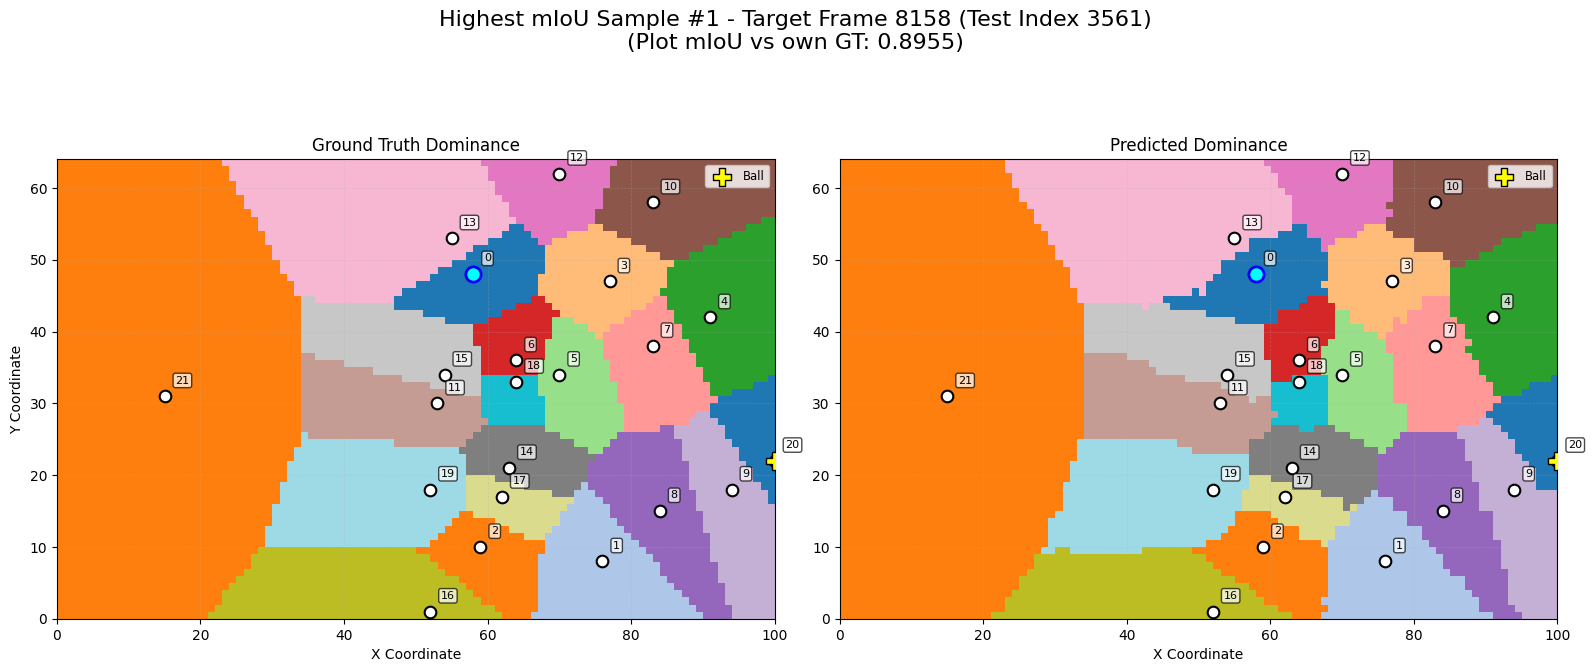

  mIoU for this plot (vs own GT): 0.8909


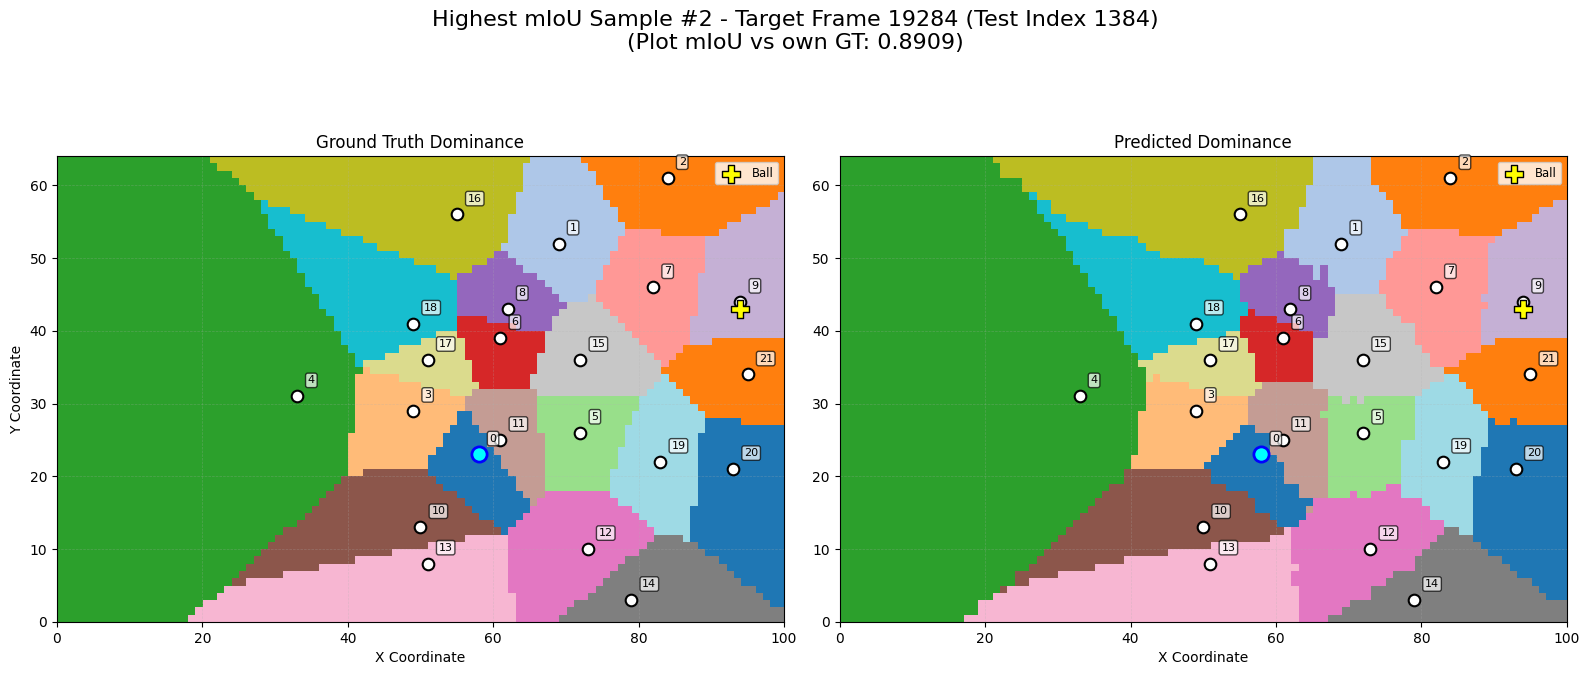

  mIoU for this plot (vs own GT): 0.8890


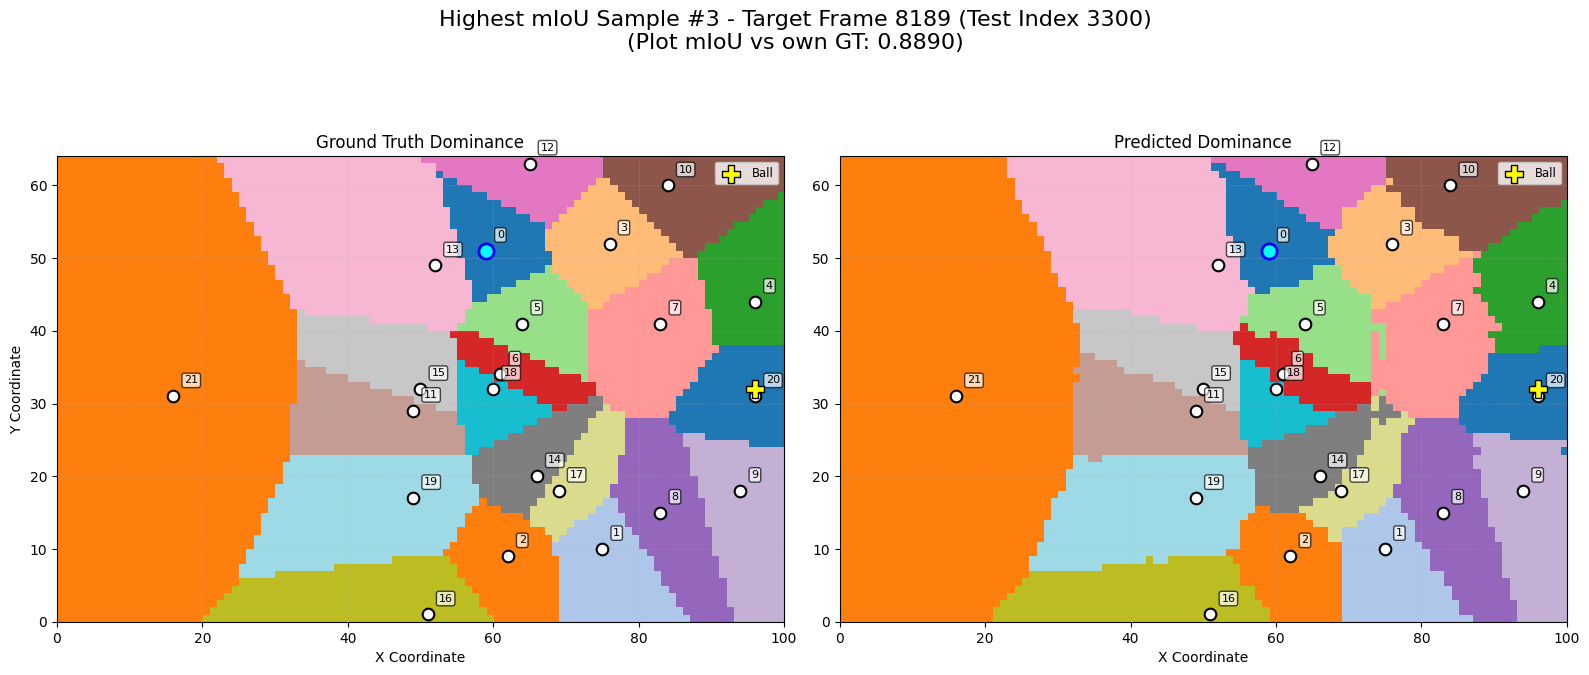

  mIoU for this plot (vs own GT): 0.0391


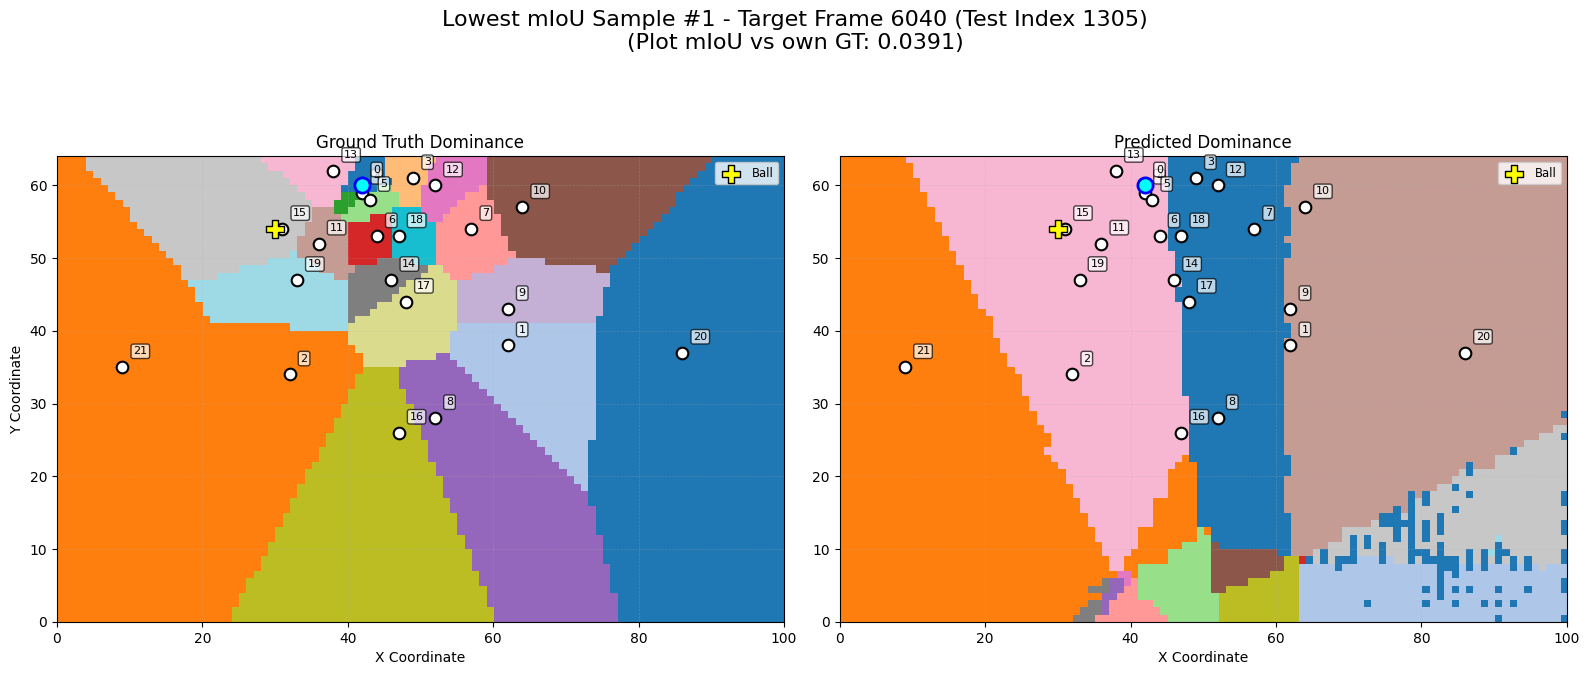

  mIoU for this plot (vs own GT): 0.0411


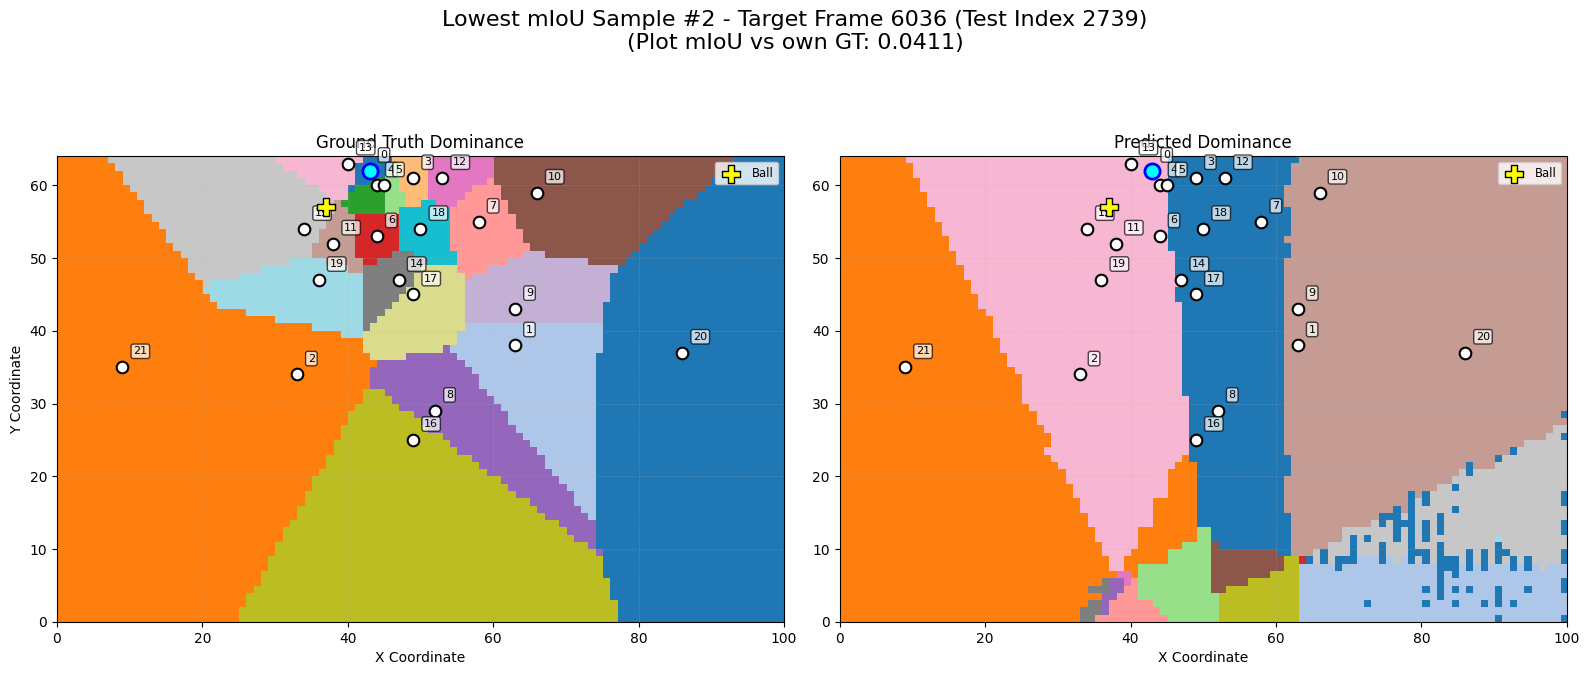

  mIoU for this plot (vs own GT): 0.2552


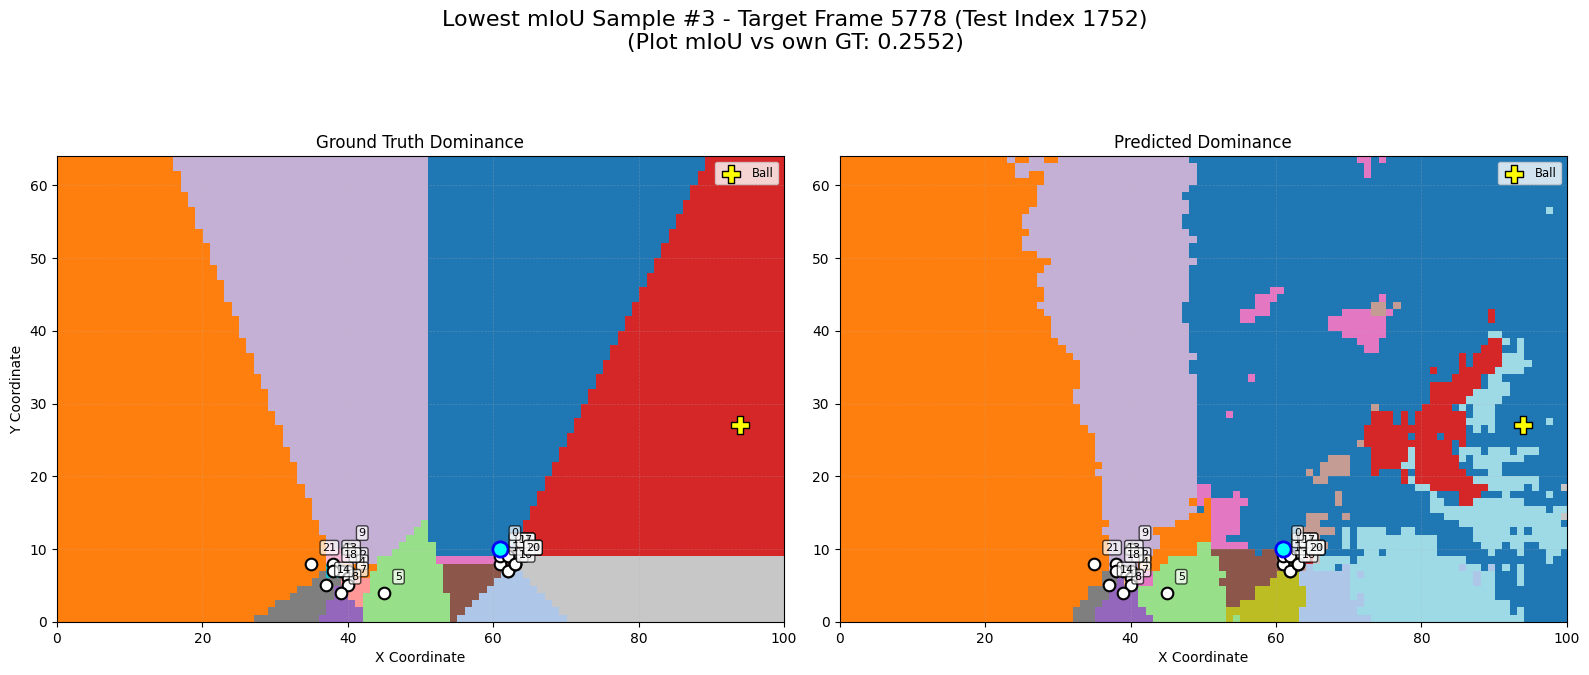

In [93]:
# find best samples
def find_top_bottom_miou_samples(model, test_data_list, num_players, ignore_index, device, top_n=3):
    model.eval()
    model.to(device)

    all_sample_mious = []

    with torch.no_grad():
        for idx, data_sample in enumerate(test_data_list):
            data_on_device = data_sample.to(device)
            target_for_iou = data_on_device.y.unsqueeze(0)
            pred_logits = model(data_on_device)
            _, batch_mean_iou_list = calculate_iou(
                pred_logits,
                target_for_iou,
                num_players,
                ignore_index
            )
            current_sample_miou = batch_mean_iou_list[0] if batch_mean_iou_list else 0.0
            all_sample_mious.append({'index': idx, 'miou': current_sample_miou})

    sorted_samples_by_miou_desc = sorted(all_sample_mious, key=lambda x: x['miou'], reverse=True)
    sorted_samples_by_miou_asc = sorted(all_sample_mious, key=lambda x: x['miou'])

    top_n_best_samples = sorted_samples_by_miou_desc[:top_n]
    top_n_worst_samples = sorted_samples_by_miou_asc[:top_n]

    return top_n_best_samples, top_n_worst_samples

N_SAMPLES_TO_SHOW = 3
top_best_samples, top_worst_samples = find_top_bottom_miou_samples(
    model=model,
    test_data_list=test_data,
    num_players=final_num_players_on_field,
    ignore_index=IGNORE_INDEX,
    device=device,
    top_n=N_SAMPLES_TO_SHOW
)

#best results 
for rank, sample_info in enumerate(top_best_samples):
    sample_to_plot = test_data[sample_info['index']]
    pred_logits, pred_map = get_prediction_outputs(model, sample_to_plot, device)
    plot_dominance_for_sensitivity(
        data_sample_to_plot=sample_to_plot,
        pred_logits_for_iou=pred_logits,
        predicted_map_np=pred_map,
        original_positions_all_for_target_frame_viz=original_positions[sample_to_plot.target_idx],
        grid_shape=(GRID_W, GRID_H),
        num_players=final_num_players_on_field,
        ignore_index_val=IGNORE_INDEX,
        device_val=device,
        title_prefix=f"Highest mIoU Sample #{rank+1}",
        title_suffix=f" (Test Index {sample_info['index']})"
    )

#worst results
for rank, sample_info in enumerate(top_worst_samples):
    sample_to_plot = test_data[sample_info['index']]
    pred_logits, pred_map = get_prediction_outputs(model, sample_to_plot, device)
    plot_dominance_for_sensitivity(
        data_sample_to_plot=sample_to_plot,
        pred_logits_for_iou=pred_logits,
        predicted_map_np=pred_map,
        original_positions_all_for_target_frame_viz=original_positions[sample_to_plot.target_idx],
        grid_shape=(GRID_W, GRID_H),
        num_players=final_num_players_on_field,
        ignore_index_val=IGNORE_INDEX,
        device_val=device,
        title_prefix=f"Lowest mIoU Sample #{rank+1}",
        title_suffix=f" (Test Index {sample_info['index']})"
    )

Analyzing Test Sample Index: 2739, Target Original Frame: 6926


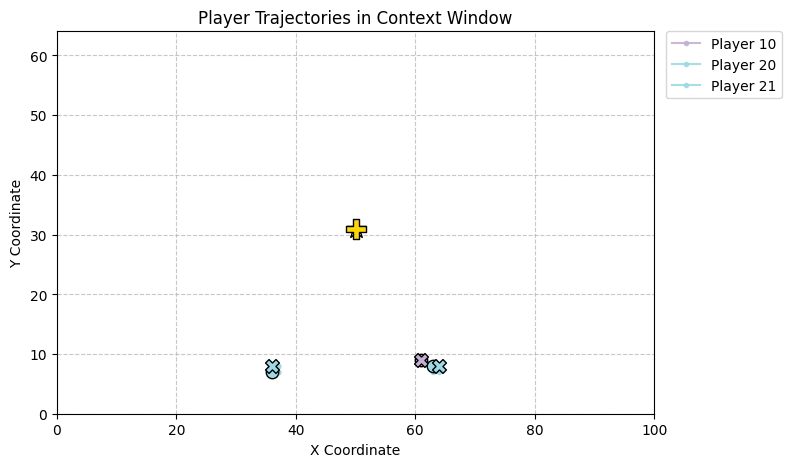

Player 10 | Frame 1: Raw [x=61.00, y=9.00, vx=-0.00, vy=-0.00, team=1.00, dist_ball=24.60, rel_bx=11.00, rel_by=-22.00], Norm [x_norm=0.33, y_norm=-1.50, vx_norm=0.00, vy_norm=0.00, team_norm=1.00, dist_ball_norm=0.03, rel_bx_norm=0.44, rel_by_norm=-1.20]
Player 10 | Frame 2: Raw [x=61.00, y=9.00, vx=-0.00, vy=-0.00, team=1.00, dist_ball=24.60, rel_bx=11.00, rel_by=-22.00], Norm [x_norm=0.33, y_norm=-1.50, vx_norm=0.00, vy_norm=0.00, team_norm=1.00, dist_ball_norm=0.03, rel_bx_norm=0.44, rel_by_norm=-1.20]
Player 10 | Frame 3: Raw [x=61.00, y=9.00, vx=-0.00, vy=-0.00, team=1.00, dist_ball=24.60, rel_bx=11.00, rel_by=-22.00], Norm [x_norm=0.33, y_norm=-1.50, vx_norm=0.00, vy_norm=0.00, team_norm=1.00, dist_ball_norm=0.03, rel_bx_norm=0.44, rel_by_norm=-1.20]
Player 10 | Frame 4: Raw [x=61.00, y=9.00, vx=-0.00, vy=-0.00, team=1.00, dist_ball=24.60, rel_bx=11.00, rel_by=-22.00], Norm [x_norm=0.33, y_norm=-1.50, vx_norm=0.00, vy_norm=0.00, team_norm=1.00, dist_ball_norm=0.03, rel_bx_norm=0

In [ ]:
def get_test_sample(test_data_list, index):
    return test_data_list[index]

# function to plot trajectories
def plot_static_context_trajectories(data_sample, original_positions_all, ball_pos_map_all,
                                     processed_frame_indices_map, num_context_frames,
                                     prediction_horizon_val,
                                     num_players_on_field,
                                     players_to_plot_indices,
                                     grid_w_val, grid_h_val,
                                     plot_title="Player Trajectories in Context Window"):

    last_context_frame_idx_in_orig_tensor = data_sample.target_idx - prediction_horizon_val
    first_context_frame_idx_in_orig_tensor = last_context_frame_idx_in_orig_tensor - num_context_frames + 1

    player_trajectories_context = original_positions_all[
        first_context_frame_idx_in_orig_tensor : last_context_frame_idx_in_orig_tensor + 1, :, :
    ].cpu().numpy()

    ball_trajectory_list = []
    for i in range(num_context_frames):
        current_processed_idx = first_context_frame_idx_in_orig_tensor + i
        original_frame_num = processed_frame_indices_map[current_processed_idx]
        ball_pos = ball_pos_map_all.get(original_frame_num)
        ball_trajectory_list.append(ball_pos if ball_pos else (np.nan, np.nan))
    ball_trajectory_context = np.array(ball_trajectory_list)

    fig, ax = plt.subplots(figsize=(10 * (grid_w_val/100), 6.4 * (grid_h_val/64)))
    ax.set_xlim(0, grid_w_val)
    ax.set_ylim(0, grid_h_val)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(plot_title)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_aspect('equal', adjustable='box')

    cmap_all_players = plt.get_cmap('tab20', num_players_on_field)

    for p_idx in players_to_plot_indices:
        x_coords = player_trajectories_context[:, p_idx, 0]
        y_coords = player_trajectories_context[:, p_idx, 1]
        ax.plot(x_coords, y_coords, marker='.', linestyle='-', color=cmap_all_players(p_idx),
                label=f'Player {p_idx}', markersize=6, linewidth=1.5, alpha=0.9)
        ax.scatter(x_coords[0], y_coords[0], color=cmap_all_players(p_idx), marker='o', s=80, edgecolor='black', zorder=5)
        ax.scatter(x_coords[-1], y_coords[-1], color=cmap_all_players(p_idx), marker='X', s=100, edgecolor='black', zorder=5)

    valid_ball_points = ~np.isnan(ball_trajectory_context).any(axis=1)
    if np.any(valid_ball_points):
        ax.plot(ball_trajectory_context[valid_ball_points, 0], ball_trajectory_context[valid_ball_points, 1],
                marker='.', linestyle='--', color='dimgray', markersize=5, linewidth=1.5, alpha=0.7)
        ax.scatter(ball_trajectory_context[valid_ball_points][0, 0], ball_trajectory_context[valid_ball_points][0, 1],
                   marker='*', s=200, color='yellow', edgecolor='black', zorder=6)
        ax.scatter(ball_trajectory_context[valid_ball_points][-1, 0], ball_trajectory_context[valid_ball_points][-1, 1],
                   marker='P', s=200, color='gold', edgecolor='black', zorder=6)

    handles, labels = ax.get_legend_handles_labels()
    unique_labels_handles = {label: handle for handle, label in zip(handles, labels)}
    ax.legend(unique_labels_handles.values(), unique_labels_handles.keys(),
              loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.80, 1])
    plt.show()

# check for subs, as if this happend it would mess up the trajecoryt
def check_substitutions(data_sample, original_df, player_id_map, num_context_frames_val, prediction_horizon_val, final_num_players_val, processed_frame_indices_map_val):
    last_context_frame_idx_in_orig_tensor = data_sample.target_idx - prediction_horizon_val
    first_context_frame_idx_in_orig_tensor = last_context_frame_idx_in_orig_tensor - num_context_frames_val + 1
    first_frame_actual_ids_at_slot = [None] * final_num_players_val
    for t_ctx in range(num_context_frames_val):
        current_processed_idx = first_context_frame_idx_in_orig_tensor + t_ctx
        original_frame_num = processed_frame_indices_map_val[current_processed_idx]
        frame_player_data = original_df[(original_df['frame'] == original_frame_num) & (original_df['player_id'] != 'ball')]
        frame_player_data = frame_player_data.sort_values(by='player_id')
        actual_ids_this_frame = frame_player_data['player_id'].astype(str).tolist()
        if t_ctx == 0:
            for slot_idx in range(final_num_players_val):
                 first_frame_actual_ids_at_slot[slot_idx] = actual_ids_this_frame[slot_idx]
        else:
            for slot_idx in range(final_num_players_val):
                current_actual_id_at_slot = actual_ids_this_frame[slot_idx]
                if first_frame_actual_ids_at_slot[slot_idx] != current_actual_id_at_slot:
                    print(f"Substitution Detected! Frame {original_frame_num}: Slot {slot_idx} changed from {first_frame_actual_ids_at_slot[slot_idx]} to {current_actual_id_at_slot}")
                    first_frame_actual_ids_at_slot[slot_idx] = current_actual_id_at_slot

# get the features
def examine_features(data_sample, players_to_examine_indices, feature_scaler, feature_names=None):
    if feature_names is None:
        feature_names = ["x", "y", "vx", "vy", "team", "dist_ball", "rel_bx", "rel_by"]
    normalized_features = data_sample.x.cpu().numpy()
    context_len, num_p, num_f = normalized_features.shape
    normalized_features_flat = normalized_features.reshape(-1, num_f)
    try:
        raw_features_flat = feature_scaler.inverse_transform(normalized_features_flat)
        raw_features = raw_features_flat.reshape(context_len, num_p, num_f)
    except:
        raw_features = None
    for player_idx_on_field in players_to_examine_indices:
        unique_player_id_int = data_sample.player_indices[0, player_idx_on_field].item()
        for t_ctx in range(context_len):
            norm_vals = normalized_features[t_ctx, player_idx_on_field, :]
            if raw_features is not None:
                raw_v = raw_features[t_ctx, player_idx_on_field, :]
                raw_vals_str = ", ".join([f"{name}={val:.2f}" for name, val in zip(feature_names, raw_v)])
            else:
                raw_vals_str = "N/A"
            norm_vals_str = ", ".join([f"{name}_norm={val:.2f}" for name, val in zip(feature_names, norm_vals)])
            print(f"Player {player_idx_on_field} | Frame {t_ctx+1}: Raw [{raw_vals_str}], Norm [{norm_vals_str}]")

sample_idx_to_analyze = 2739
players_of_interest_indices = [10, 20, 21]

problem_sample = get_test_sample(test_data, sample_idx_to_analyze)

print(f"Analyzing Test Sample Index: {sample_idx_to_analyze}, Target Original Frame: {processed_frame_indices[problem_sample.target_idx]}")

plot_static_context_trajectories(
    problem_sample,
    original_positions,
    ball_pos_map,
    processed_frame_indices,
    num_frames_context,
    prediction_horizon,
    final_num_players_on_field,
    players_to_plot_indices=players_of_interest_indices,
    grid_w_val=GRID_W,
    grid_h_val=GRID_H
)

check_substitutions(
    problem_sample,
    df,
    player_id_to_idx,
    num_frames_context,
    prediction_horizon,
    final_num_players_on_field,
    processed_frame_indices
)

examine_features(problem_sample, players_of_interest_indices, scaler)

# Reference: PyTorch Documentation. https://pytorch.org/docs/stable/index.html